## CHPT Stock

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',100)

In [2]:
chpt = yf.download('CHPT')

[*********************100%***********************]  1 of 1 completed


In [3]:
chpt = chpt.Close.to_frame()

In [4]:
chpt['d_returns'] = np.log(chpt.div(chpt.shift(1)))

In [5]:
chpt

Close  d_returns
Date                         
2019-09-16  9.7600        NaN
2019-09-17  9.7600   0.000000
2019-09-18  9.7200  -0.004107
2019-09-19  9.7200   0.000000
2019-09-20  9.8500   0.013286
...            ...        ...
2023-12-13  2.4000   0.077962
2023-12-14  2.9000   0.189242
2023-12-15  2.7200  -0.064079
2023-12-18  2.6800  -0.014815
2023-12-19  2.6799  -0.000037

[1074 rows x 2 columns]

In [6]:
chpt.dropna(inplace=True)

In [7]:
chpt.d_returns.sum()

-1.292512969246646

In [8]:
np.exp(chpt.d_returns.sum())

0.27457990451922376

In [9]:
chpt['cumm_returns'] = chpt.d_returns.cumsum().apply(np.exp)
chpt

Close  d_returns  cumm_returns
Date                                       
2019-09-17  9.7600   0.000000      1.000000
2019-09-18  9.7200  -0.004107      0.995902
2019-09-19  9.7200   0.000000      0.995902
2019-09-20  9.8500   0.013286      1.009221
2019-09-23  9.8500   0.000000      1.009221
...            ...        ...           ...
2023-12-13  2.4000   0.077962      0.245902
2023-12-14  2.9000   0.189242      0.297131
2023-12-15  2.7200  -0.064079      0.278689
2023-12-18  2.6800  -0.014815      0.274590
2023-12-19  2.6799  -0.000037      0.274580

[1073 rows x 3 columns]

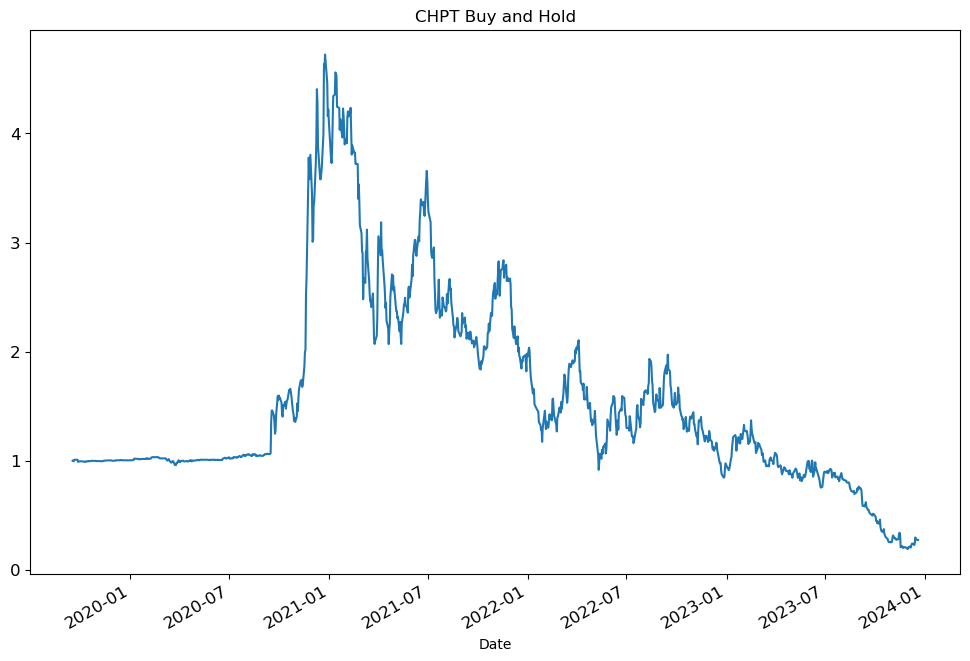

In [10]:
chpt.cumm_returns.plot(figsize=(12,8), title='CHPT Buy and Hold', fontsize=12)
plt.show()

In [11]:
chpt.d_returns.mean()*252

-0.3035538380709737

In [12]:
chpt.d_returns.std()*np.sqrt(252)

0.759555597320112

In [13]:
# Calculating draw downs (finding the peaks and valleys)
chpt['cumm_max'] = chpt.cumm_returns.cummax()

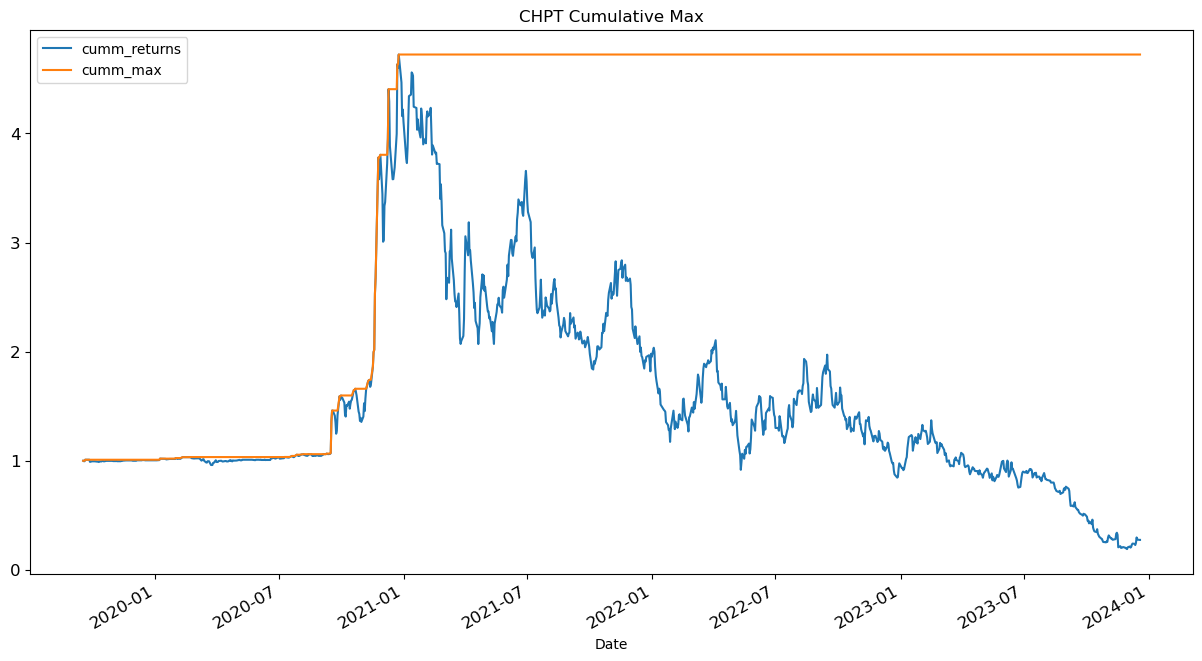

In [14]:
chpt[["cumm_returns","cumm_max"]].plot(figsize=(15,8), title='CHPT Cumulative Max', fontsize=12)
plt.show()

In [15]:
chpt['draw_down'] = chpt['cumm_max'] - chpt['cumm_returns']

In [16]:
chpt.draw_down.max()

4.532786621141748

In [17]:
chpt.draw_down.idxmax()

Timestamp('2023-11-30 00:00:00')

In [18]:
# Calculating drawdown percentage
chpt['draw_down_percentage'] = (chpt['cumm_max'] - chpt['cumm_returns']) / chpt['cumm_max']

In [19]:
chpt.draw_down_percentage.max()

0.9596529267707188

In [20]:
chpt.draw_down_percentage.idxmax()

Timestamp('2023-11-30 00:00:00')

In [21]:
chpt.loc[(chpt.index<='2023-11-30')]

Close  d_returns  cumm_returns  cumm_max  draw_down  \
Date                                                              
2019-09-17   9.76   0.000000      1.000000  1.000000   0.000000   
2019-09-18   9.72  -0.004107      0.995902  1.000000   0.004098   
2019-09-19   9.72   0.000000      0.995902  1.000000   0.004098   
2019-09-20   9.85   0.013286      1.009221  1.009221   0.000000   
2019-09-23   9.85   0.000000      1.009221  1.009221   0.000000   
...           ...        ...           ...       ...        ...   
2023-11-24   2.04   0.034916      0.209016  4.723360   4.514344   
2023-11-27   1.99  -0.024815      0.203893  4.723360   4.519467   
2023-11-28   1.93  -0.030615      0.197746  4.723360   4.525614   
2023-11-29   1.96   0.015425      0.200820  4.723360   4.522541   
2023-11-30   1.86  -0.052368      0.190574  4.723360   4.532787   

            draw_down_percentage  
Date                              
2019-09-17              0.000000  
2019-09-18              0.004098  
2019-09-19              0.004098  
2019-09-20              0.000000  
2019-09-23              0.000000  
...                          ...  
2023-11-24              0.955748  
2023-11-27              0.956833  
2023-11-28              0.958134  
2023-11-29              0.957484  
2023-11-30              0.959653  

[1060 rows x 6 columns]

## SMA Strategy (CHPT)

In [22]:
data = chpt.Close.loc[(chpt.index>='1991-01-01')]
data = data.to_frame()

In [23]:
# moving averages

sma_s = 25
sma_l = 50


data['sma_s'] = data.Close.rolling(sma_s).mean()
data['sma_l'] = data.Close.rolling(sma_l).mean()

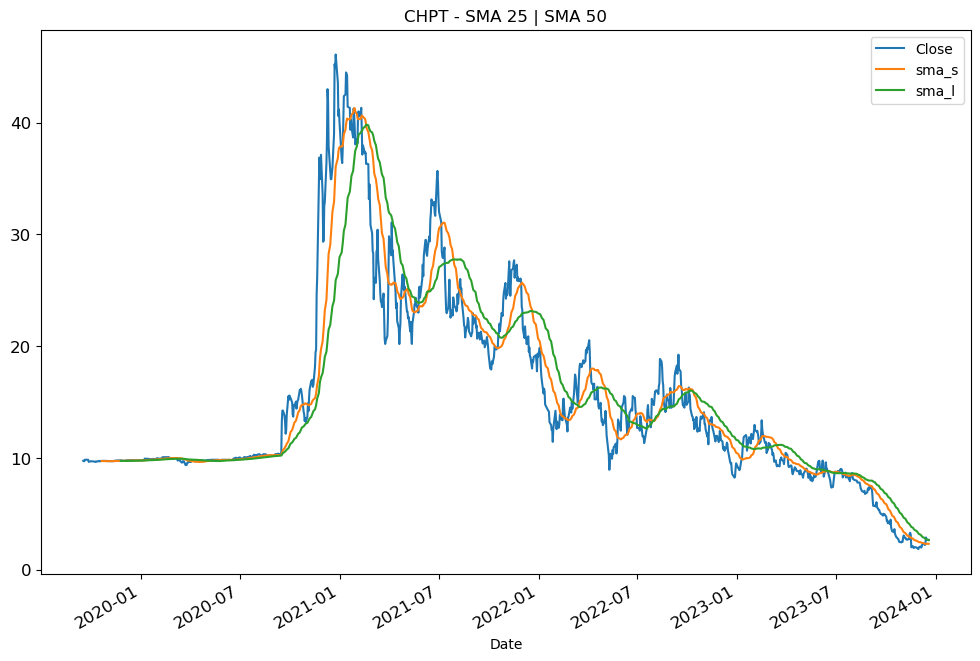

In [24]:
data.plot(figsize=(12,8), title='CHPT - SMA {} | SMA {}'.format(sma_s, sma_l), fontsize=12);

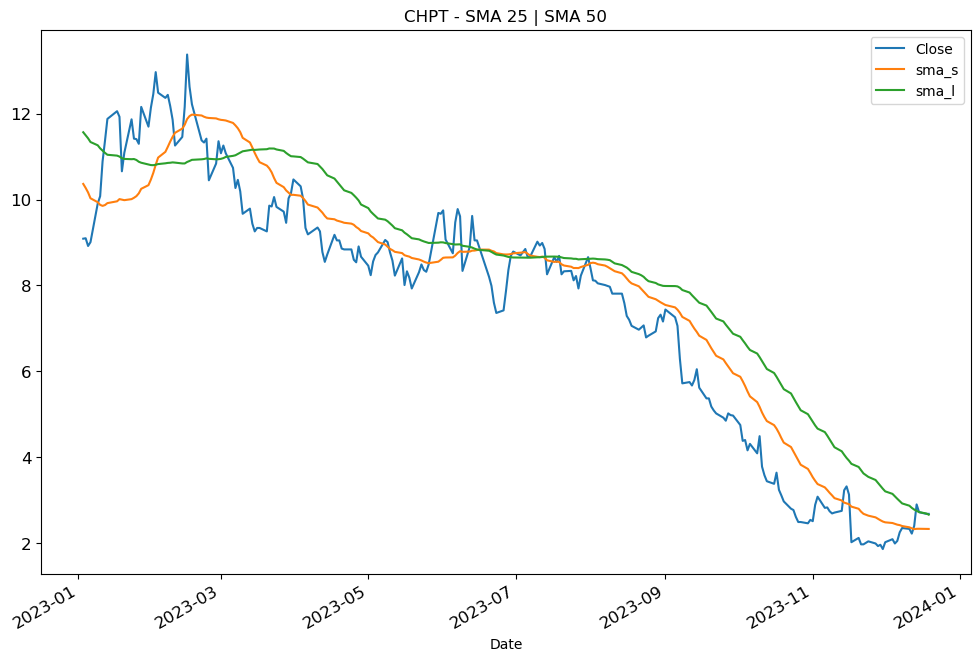

In [25]:
data.loc['2023'].plot(figsize=(12,8), title='CHPT - SMA {} | SMA {}'.format(sma_s, sma_l), fontsize=12);
data.dropna(inplace=True)

In [26]:
data['position'] = np.where(data['sma_s']>data['sma_l'], 1, -1)
data

Close     sma_s     sma_l  position
Date                                            
2019-11-25  9.7900  9.752800  9.744500         1
2019-11-26  9.7900  9.754400  9.745100         1
2019-11-27  9.7900  9.756000  9.746500         1
2019-11-29  9.7600  9.756400  9.747300         1
2019-12-02  9.7600  9.756800  9.745500         1
...            ...       ...       ...       ...
2023-12-13  2.4000  2.325200  2.780200        -1
2023-12-14  2.9000  2.331600  2.750200        -1
2023-12-15  2.7200  2.332800  2.721400        -1
2023-12-18  2.6800  2.331600  2.688800        -1
2023-12-19  2.6799  2.328796  2.660598        -1

[1024 rows x 4 columns]

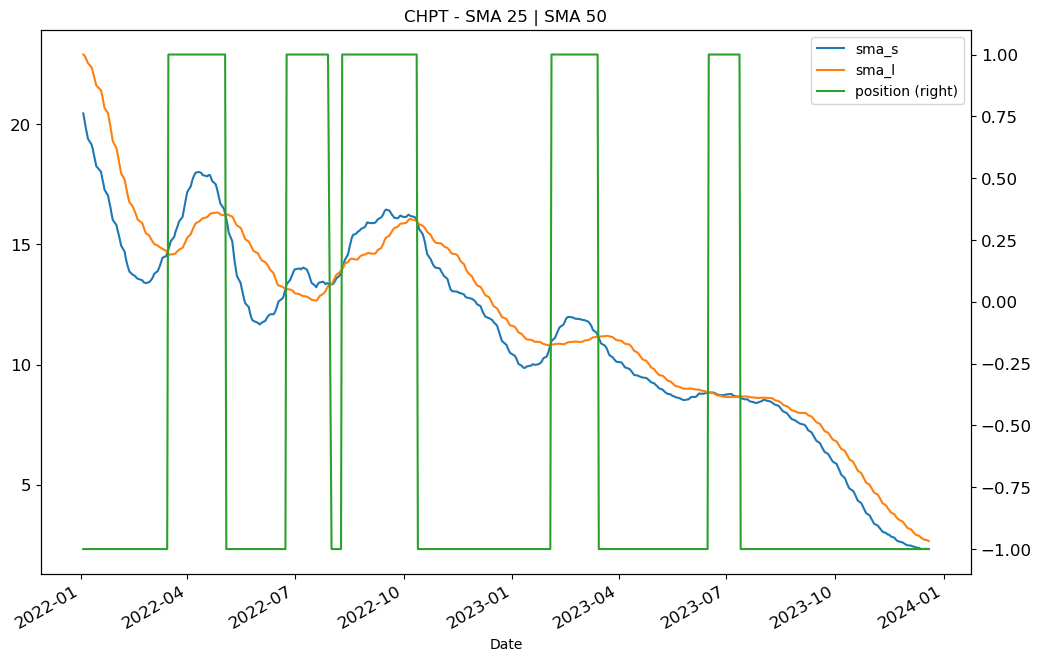

In [27]:
data.loc['2022':'2023',["sma_s", "sma_l",'position']].plot(figsize=(12,8), title='CHPT - SMA {} | SMA {}'.format(sma_s, sma_l), fontsize=12,secondary_y='position');

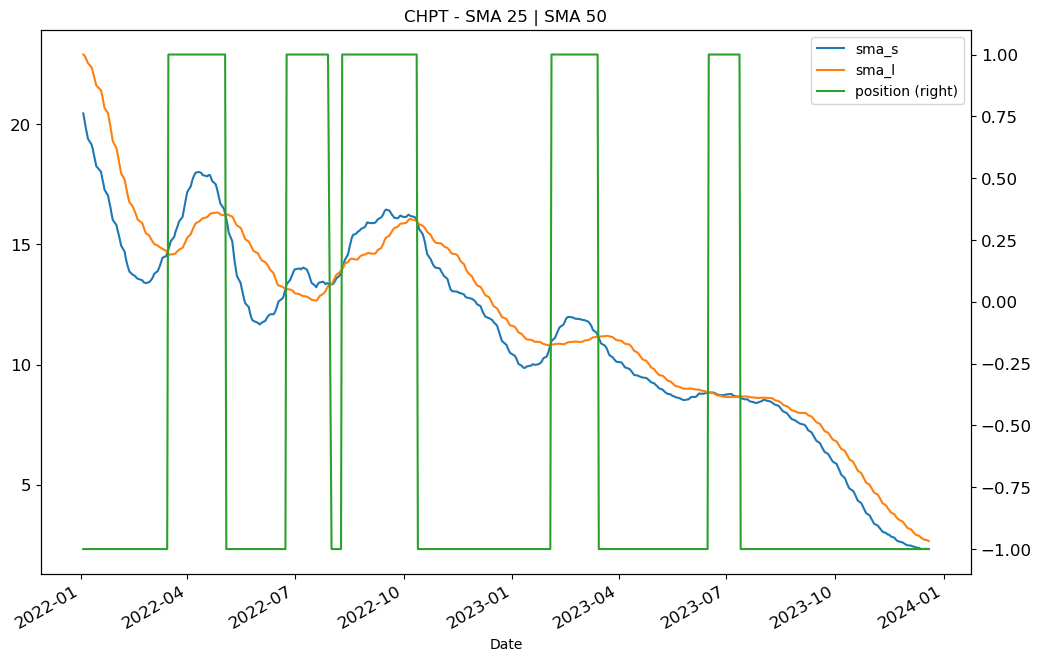

In [28]:
data.loc['2022':'2023',["sma_s", "sma_l",'position']].plot(figsize=(12,8), title='CHPT - SMA {} | SMA {}'.format(sma_s, sma_l), fontsize=12,secondary_y='position');

In [29]:
# buy and hold column
data['returns_bnh'] = np.log(data.Close.div(data.Close.shift(1)))

In [30]:
# strategy column
data['strategy'] = data['returns_bnh'] * data.position.shift(1)
data.dropna(inplace=True)

In [31]:
data[['returns_bnh','strategy']].sum()

returns_bnh   -1.295582
strategy       1.462691
dtype: float64

In [32]:
data[['returns_bnh','strategy']].sum().apply(np.exp)

returns_bnh    0.273739
strategy       4.317562
dtype: float64

In [33]:
data[['returns_bnh','strategy']].std()*np.sqrt(252) # annual std

returns_bnh    0.777786
strategy       0.777715
dtype: float64

### Strategy 2

In [34]:
data['position2'] = np.where(data['sma_s']>data['sma_l'], 1, 0)
data['strategy2'] = data['returns_bnh'] * data.position2.shift(1)
data.dropna(inplace=True)

In [35]:
data[['returns_bnh','strategy2']].sum()

returns_bnh   -1.295582
strategy2      0.083554
dtype: float64

In [36]:
data[['returns_bnh','strategy2']].sum().apply(np.exp)

returns_bnh    0.273739
strategy2      1.087144
dtype: float64

In [37]:
data[['returns_bnh','strategy2']].std()*np.sqrt(252) # risk

returns_bnh    0.778167
strategy2      0.484472
dtype: float64

In [38]:
data[['strategy','strategy2']].std()*np.sqrt(252) # risk

strategy     0.778095
strategy2    0.484472
dtype: float64

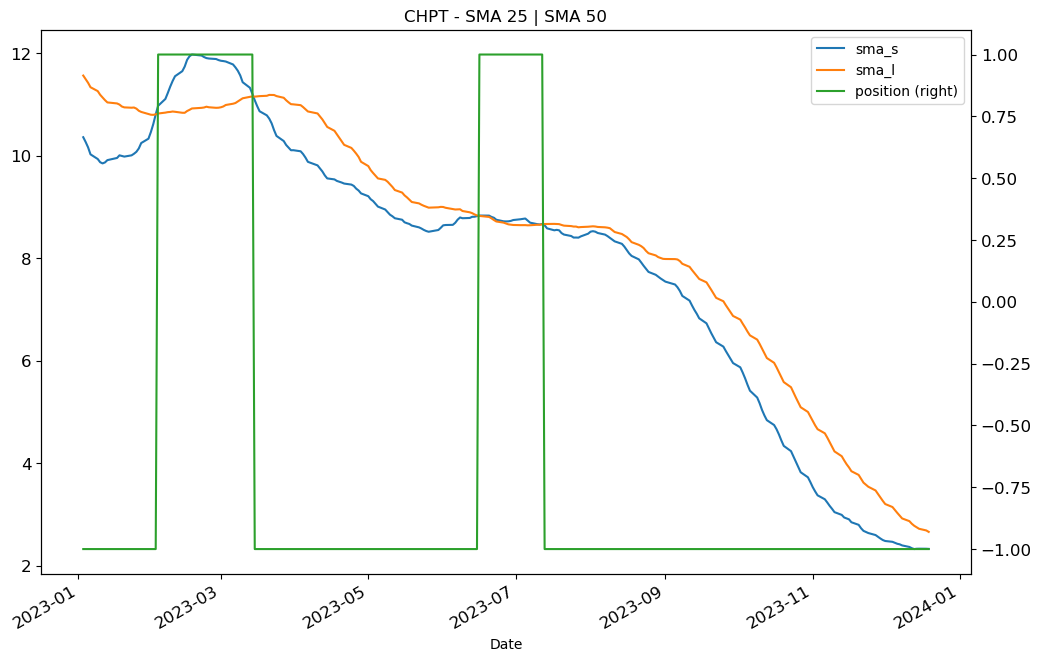

In [39]:
data.loc['2023',["sma_s", "sma_l",'position']].plot(figsize=(12,8), title='CHPT - SMA {} | SMA {}'.format(sma_s, sma_l), fontsize=12,secondary_y='position');

# Function

In [40]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def combined_analysis(stock_symbol, sma_short=25, sma_long=50, bb_window=20, bb_num_std=2, rsi_window=14,
                      macd_short_window=12, macd_long_window=26, macd_signal_window=9,
                      start_date=None, end_date=None):
    # Download stock data
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

    # Extract closing prices
    stock_close = stock_data['Close'].to_frame()

    # Calculate daily returns
    stock_close['d_returns'] = np.log(stock_close.div(stock_close.shift(1)))
    stock_close.dropna(inplace=True)

    # Calculate cumulative returns
    stock_close['cumm_returns'] = stock_close['d_returns'].cumsum().apply(np.exp)

    # Plot cumulative returns
    stock_close['cumm_returns'].plot(figsize=(12, 8), title=f'{stock_symbol} Buy and Hold', fontsize=12)
    plt.show()

    # Simple Moving Average (SMA) Strategy
    stock_close['sma_short'] = stock_close['Close'].rolling(sma_short).mean()
    stock_close['sma_long'] = stock_close['Close'].rolling(sma_long).mean()

    # Generate buy and sell signals
    stock_close['position'] = np.where(stock_close['sma_short'] > stock_close['sma_long'], 1, -1)

    # Plot SMA strategy
    stock_close[['Close', 'sma_short', 'sma_long']].plot(figsize=(12, 8), title=f'{stock_symbol} - SMA {sma_short} | SMA {sma_long}', fontsize=12)
    plt.show()

    # Plot buy and sell positions
    stock_close['position'].plot(ylim=[-1.1, 1.1], figsize=(12, 8), title=f'{stock_symbol} - Buy and Sell Positions', fontsize=12)
    plt.show()

    # Bollinger Bands Analysis
    stock_close['sma'] = stock_close['Close'].rolling(bb_window).mean()
    stock_close['upper_band'] = stock_close['sma'] + (bb_num_std * stock_close['Close'].rolling(bb_window).std())
    stock_close['lower_band'] = stock_close['sma'] - (bb_num_std * stock_close['Close'].rolling(bb_window).std())

    # Plot Bollinger Bands
    stock_close[['Close', 'sma', 'upper_band', 'lower_band']].plot(figsize=(12, 8), title=f'{stock_symbol} - Bollinger Bands', fontsize=12)
    plt.show()

    # RSI Analysis
    delta = stock_close['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(rsi_window).mean()
    avg_loss = loss.rolling(rsi_window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # Plot RSI
    rsi.plot(figsize=(12, 8), title=f'{stock_symbol} - Relative Strength Index (RSI)', fontsize=12)
    plt.axhline(70, color='r', linestyle='--', label='Overbought (70)')
    plt.axhline(30, color='g', linestyle='--', label='Oversold (30)')
    plt.legend()
    plt.show()

    # MACD Analysis
    stock_close['short_ema'] = stock_close['Close'].ewm(span=macd_short_window, adjust=False).mean()
    stock_close['long_ema'] = stock_close['Close'].ewm(span=macd_long_window, adjust=False).mean()
    stock_close['macd'] = stock_close['short_ema'] - stock_close['long_ema']
    stock_close['signal'] = stock_close['macd'].ewm(span=macd_signal_window, adjust=False).mean()

    # Plot MACD
    stock_close[['Close', 'macd', 'signal']].plot(figsize=(12, 8), title=f'{stock_symbol} - Moving Average Convergence Divergence (MACD)', fontsize=12)
    plt.show()

    # Calculate and Print Risk and Return
    total_return = stock_close['cumm_returns'][-1] - 1
    annualized_return = (1 + total_return) ** (252 / len(stock_close.index)) - 1
    annualized_volatility = stock_close['d_returns'].std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility

    print(f'Total Return: {total_return:.2%}')
    print(f'Annualized Return: {annualized_return:.2%}')
    print(f'Annualized Volatility: {annualized_volatility:.2%}')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

    # Calculate and Print Profit/Loss
    buy_signals = stock_close[stock_close['position'] == 1]
    sell_signals = stock_close[stock_close['position'] == -1]

    for buy_index, sell_index in zip(buy_signals.index, sell_signals.index):
        buy_price = stock_close['Close'].loc[buy_index]
        sell_price = stock_close['Close'].loc[sell_index]
        quantity = 1  # You can modify this based on

# Results

[*********************100%***********************]  1 of 1 completed


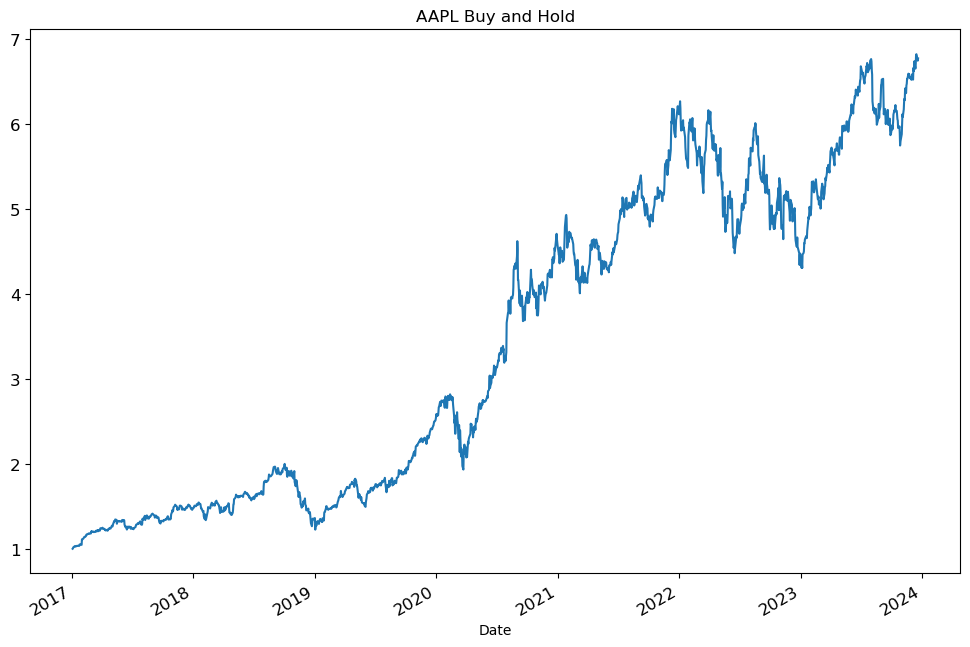

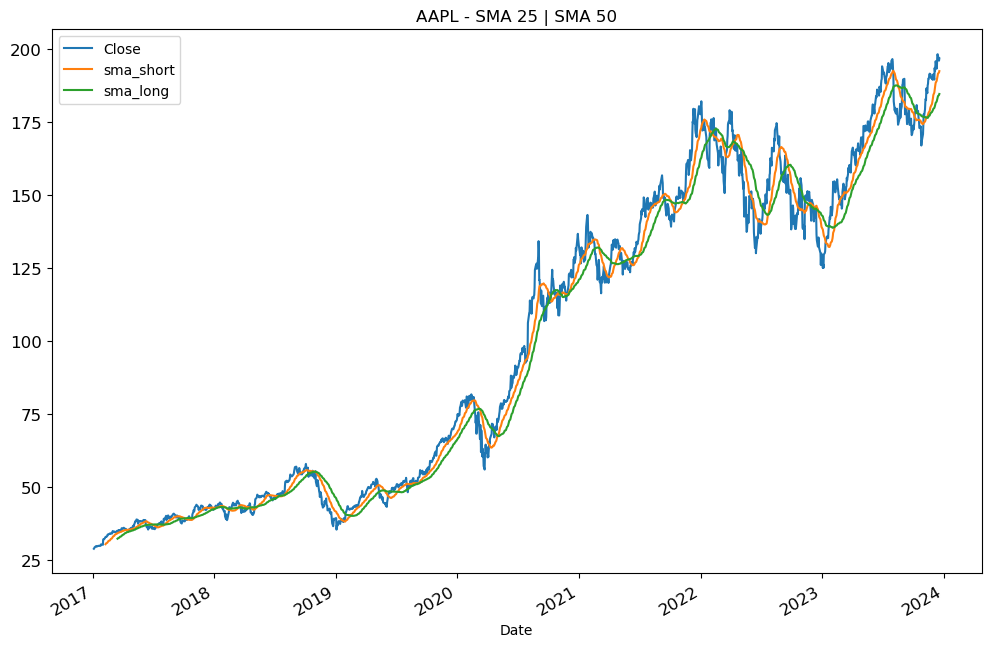

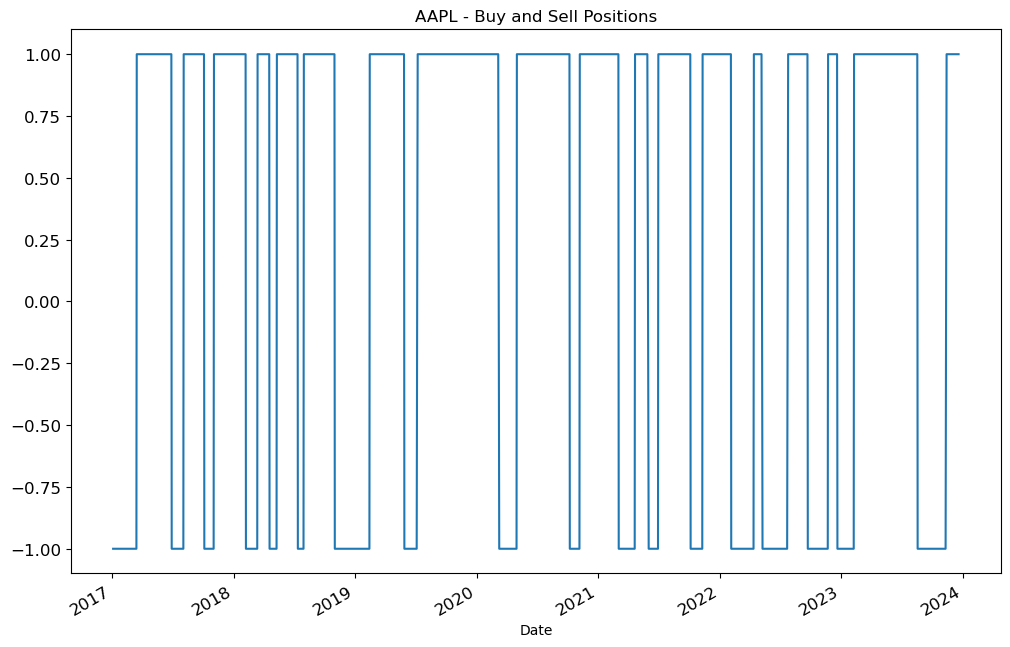

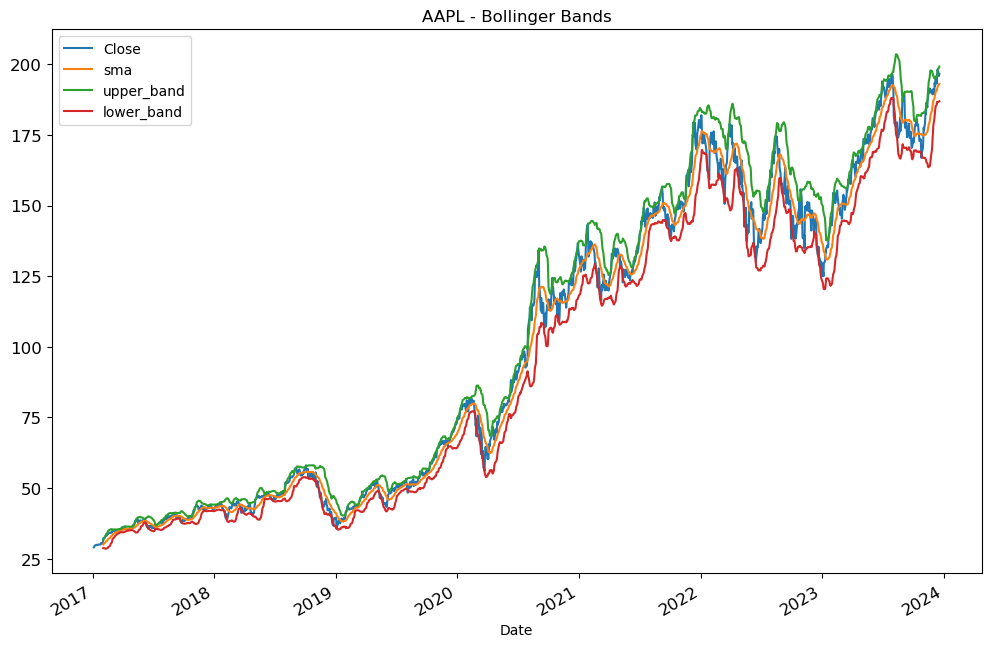

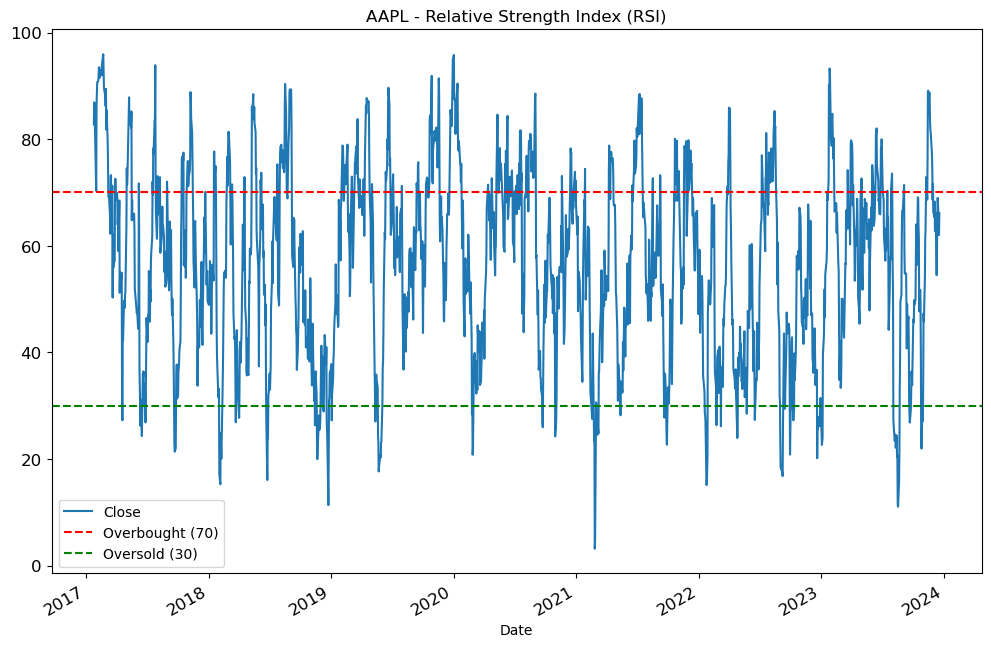

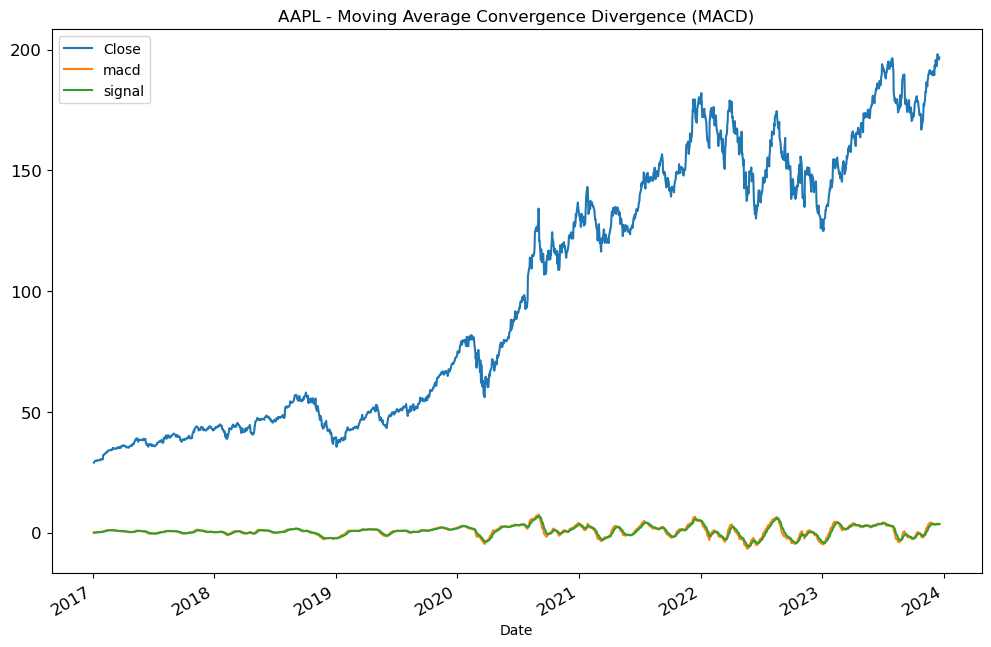

Total Return: 577.26%
Annualized Return: 31.67%
Annualized Volatility: 30.15%
Sharpe Ratio: 1.05


In [41]:
combined_analysis('AAPL', start_date='2017-01-01', end_date='2023-12-31')

[*********************100%***********************]  1 of 1 completed


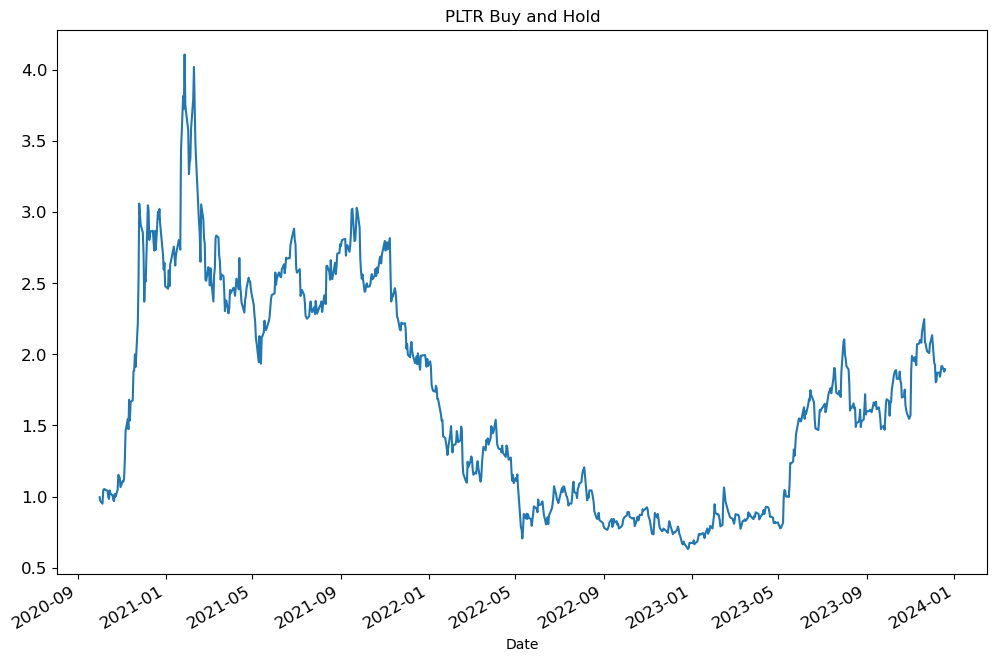

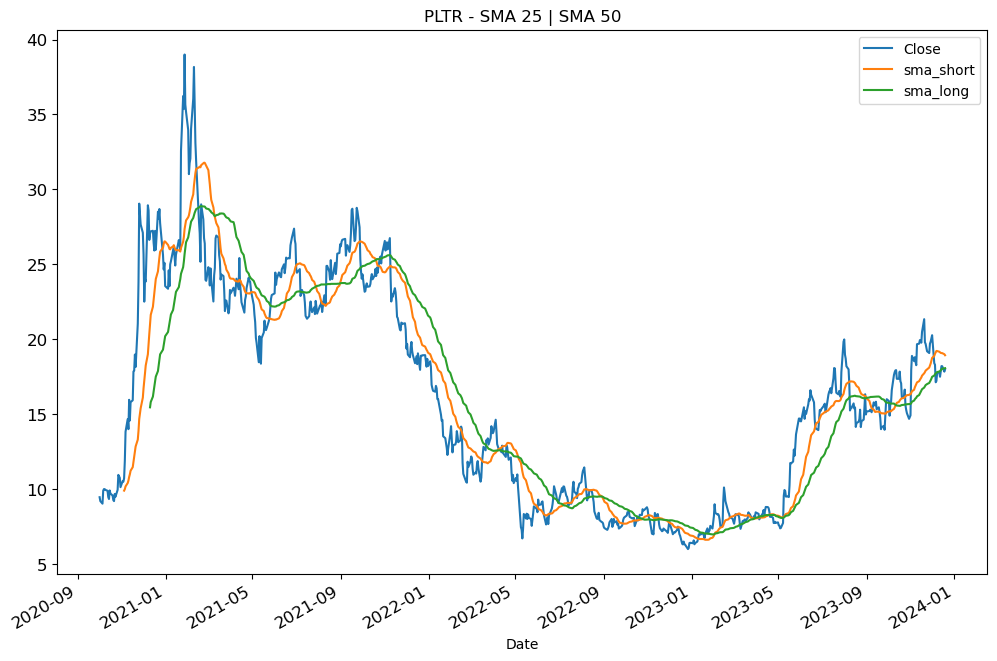

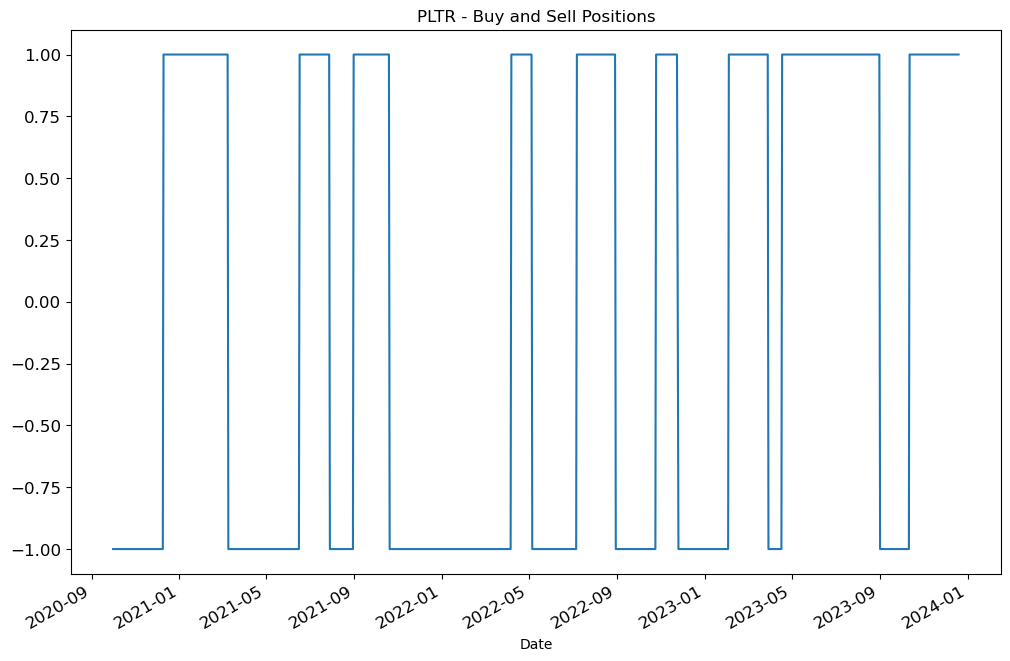

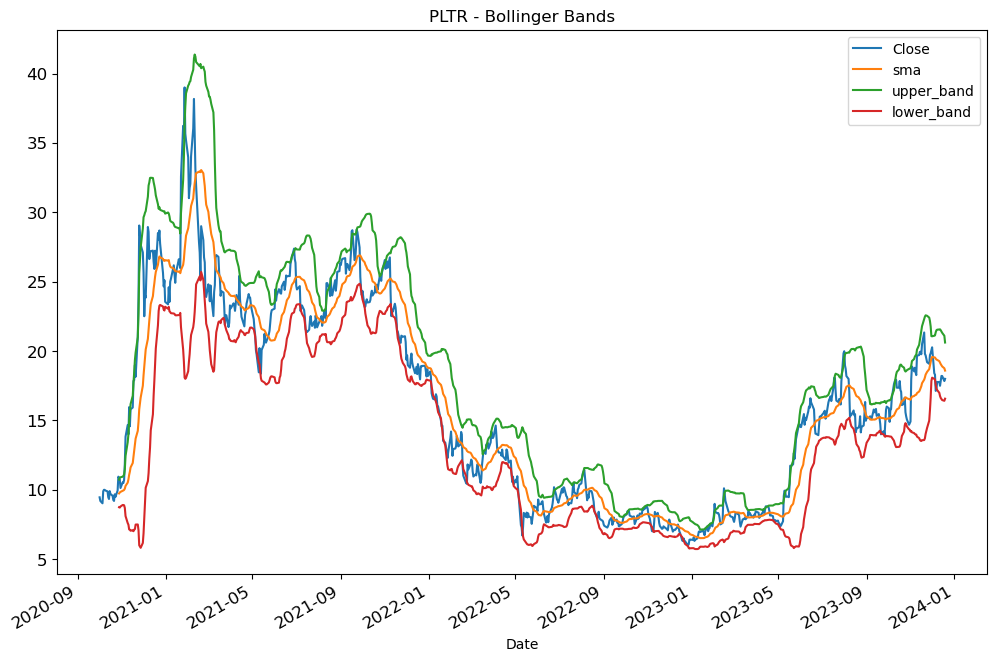

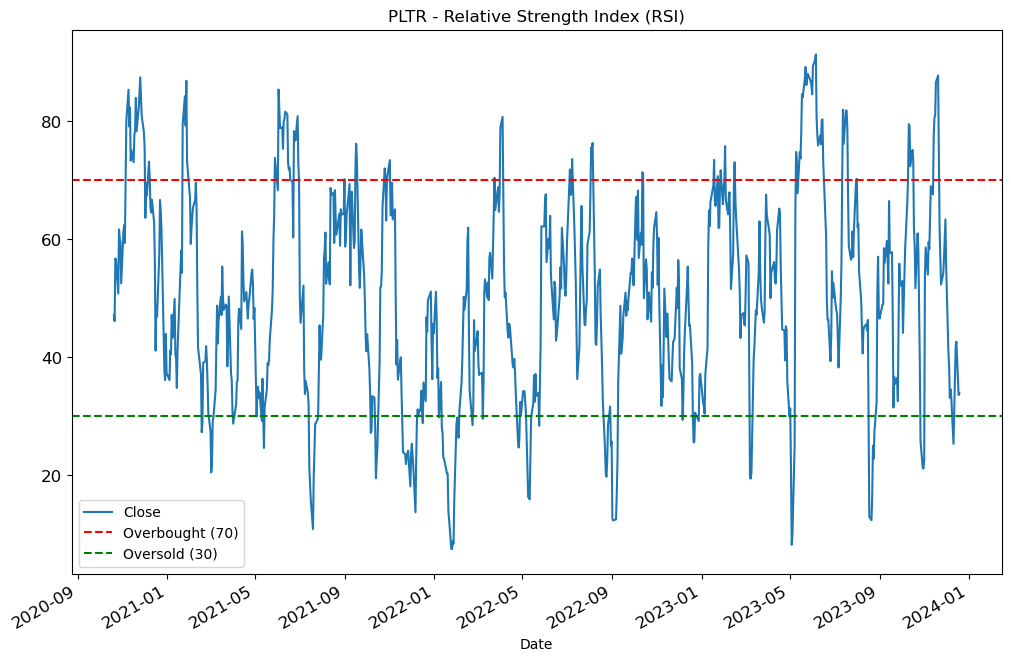

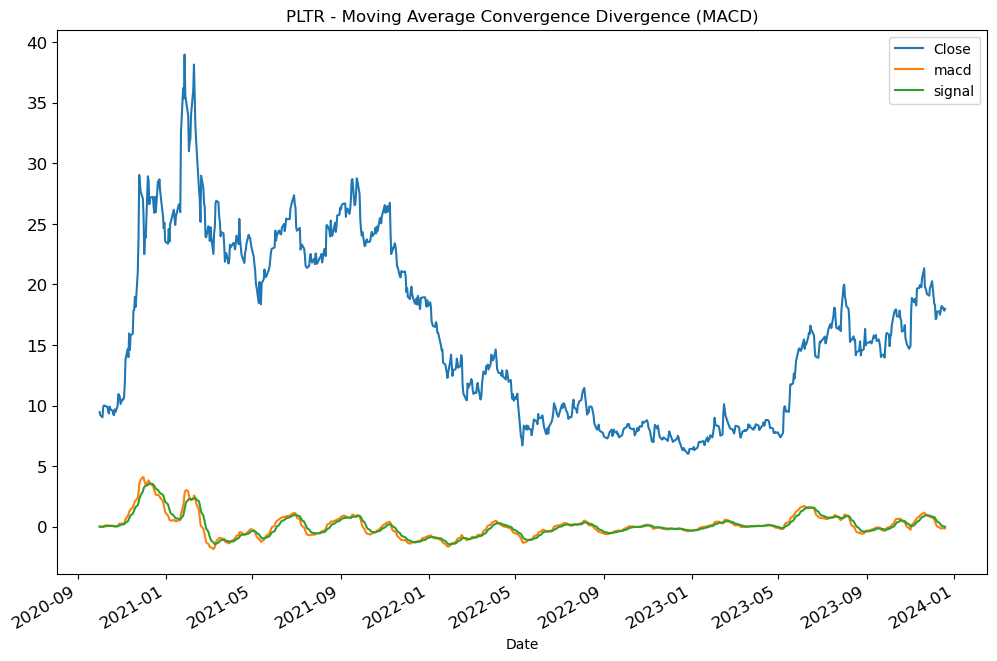

Total Return: 89.47%
Annualized Return: 22.00%
Annualized Volatility: 72.82%
Sharpe Ratio: 0.30


In [42]:
combined_analysis('PLTR', start_date='2010-01-01', end_date='2023-12-31')

[*********************100%***********************]  1 of 1 completed


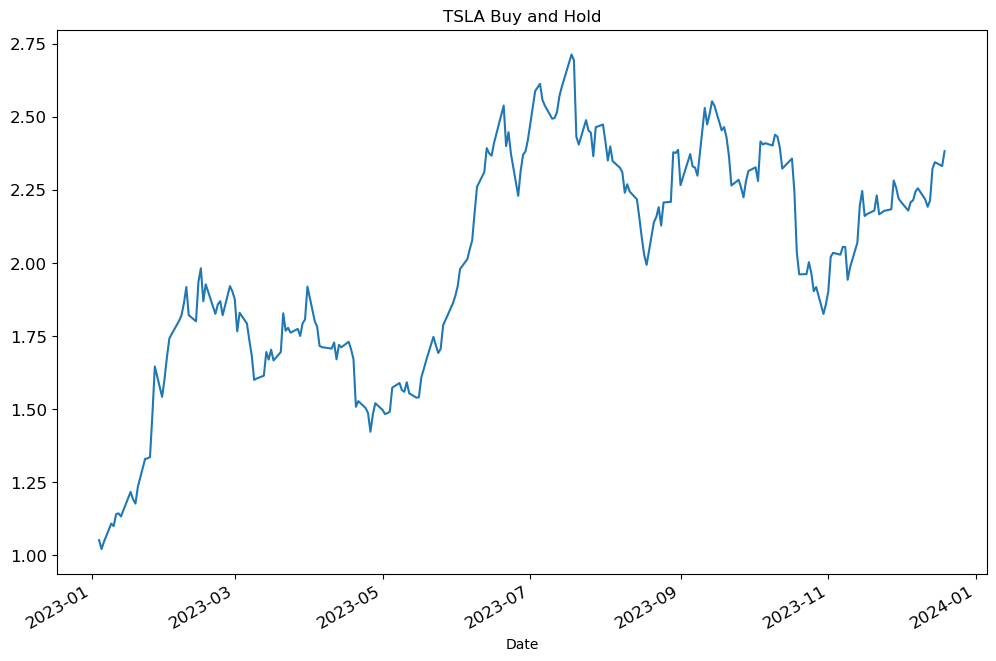

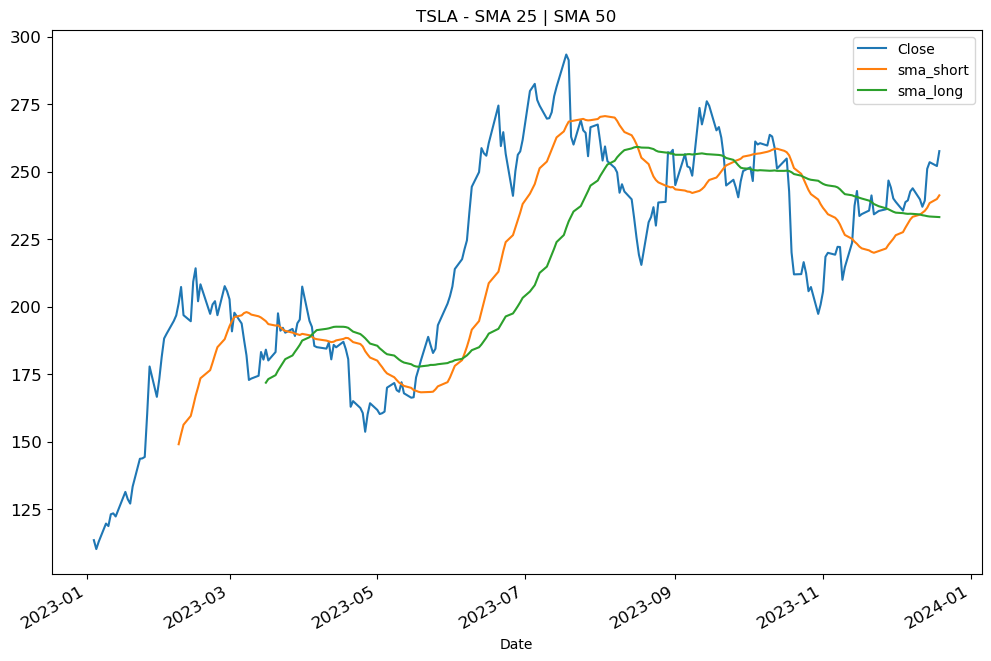

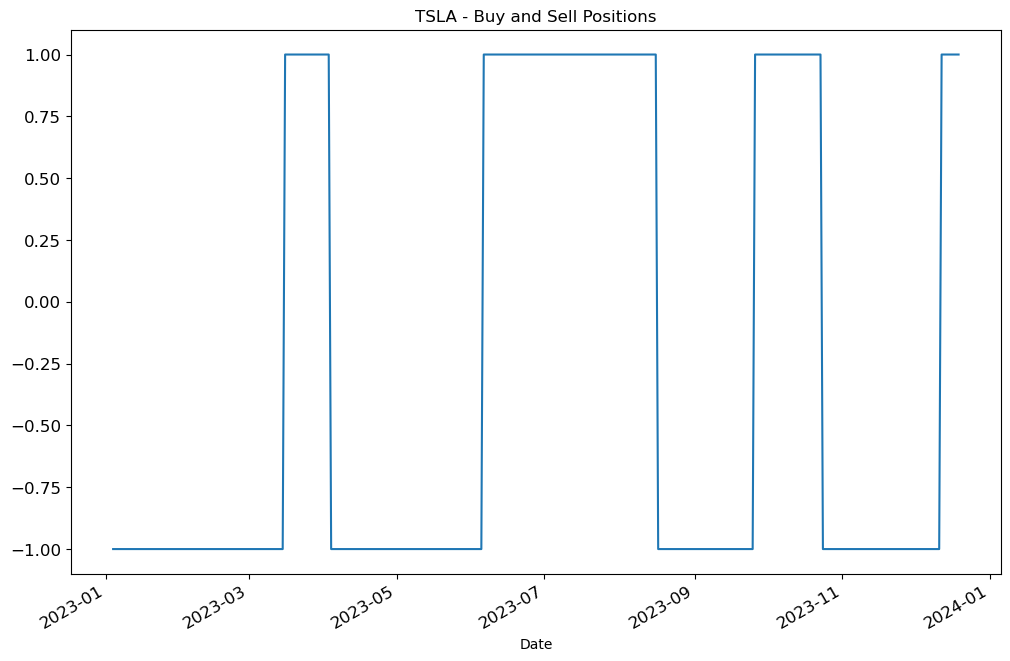

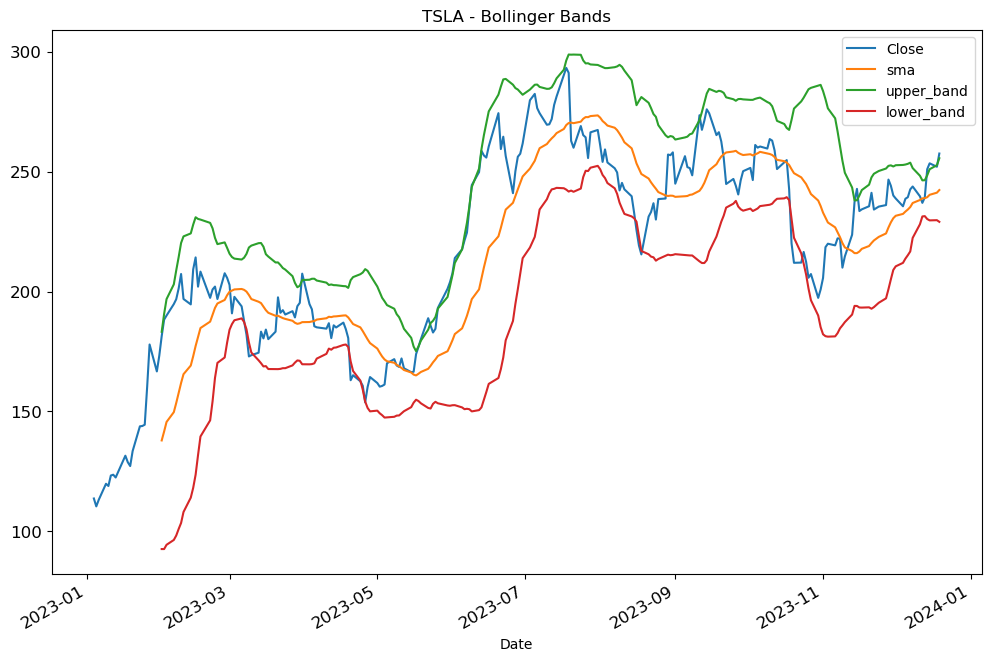

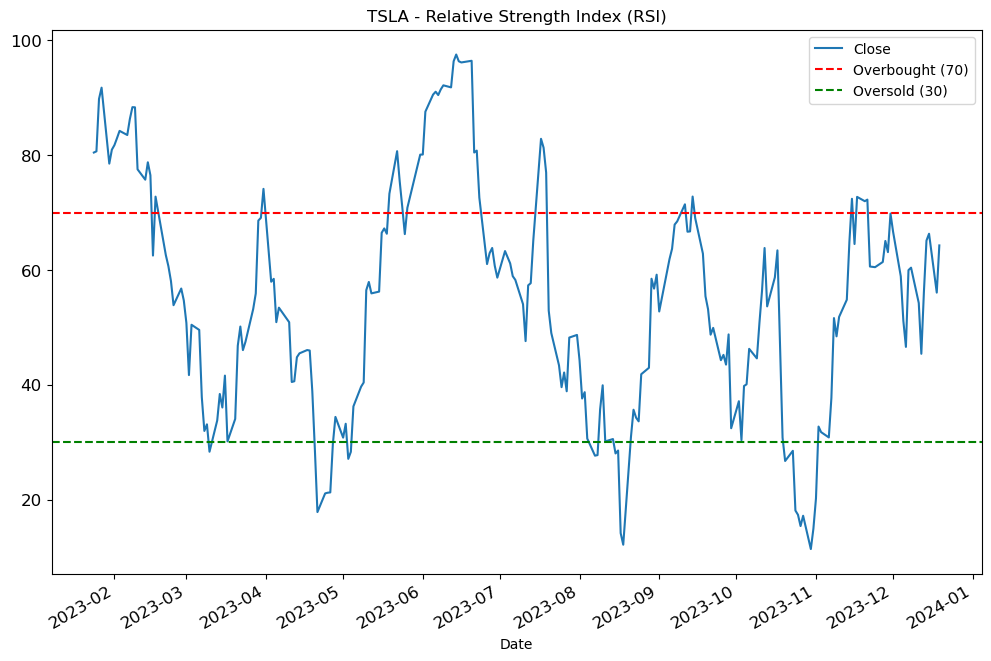

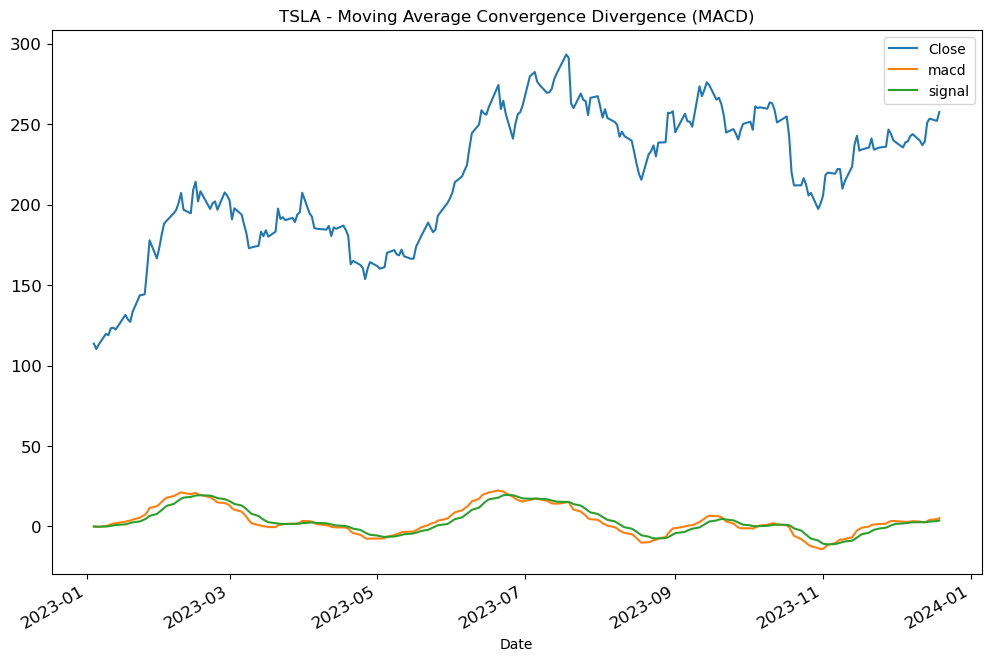

Total Return: 138.29%
Annualized Return: 147.00%
Annualized Volatility: 52.67%
Sharpe Ratio: 2.79


In [43]:
combined_analysis('TSLA', start_date='2023-01-01', end_date='2023-12-31')

[*********************100%***********************]  1 of 1 completed


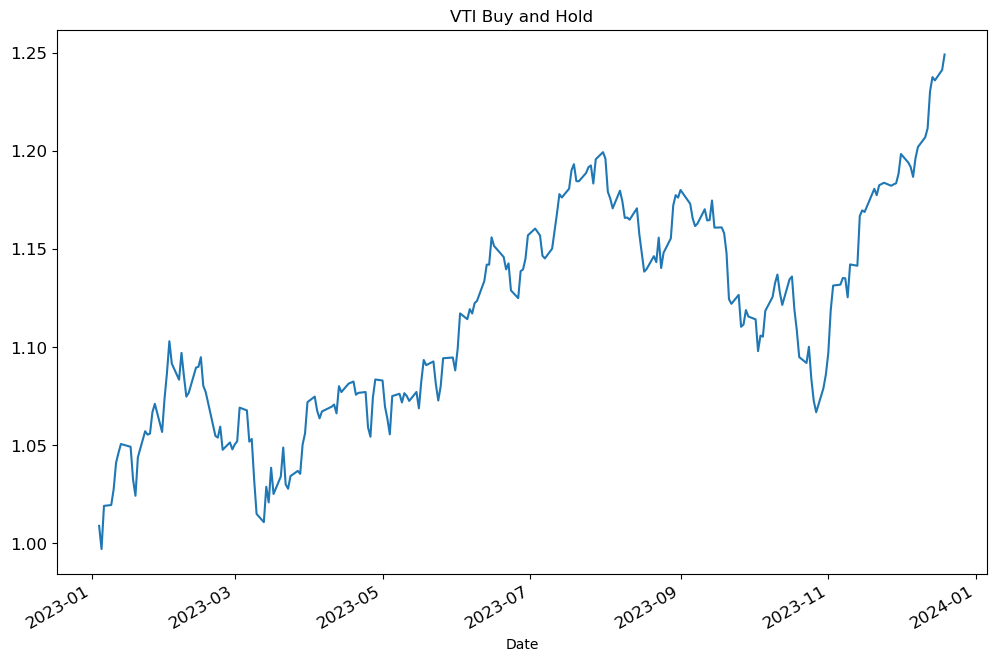

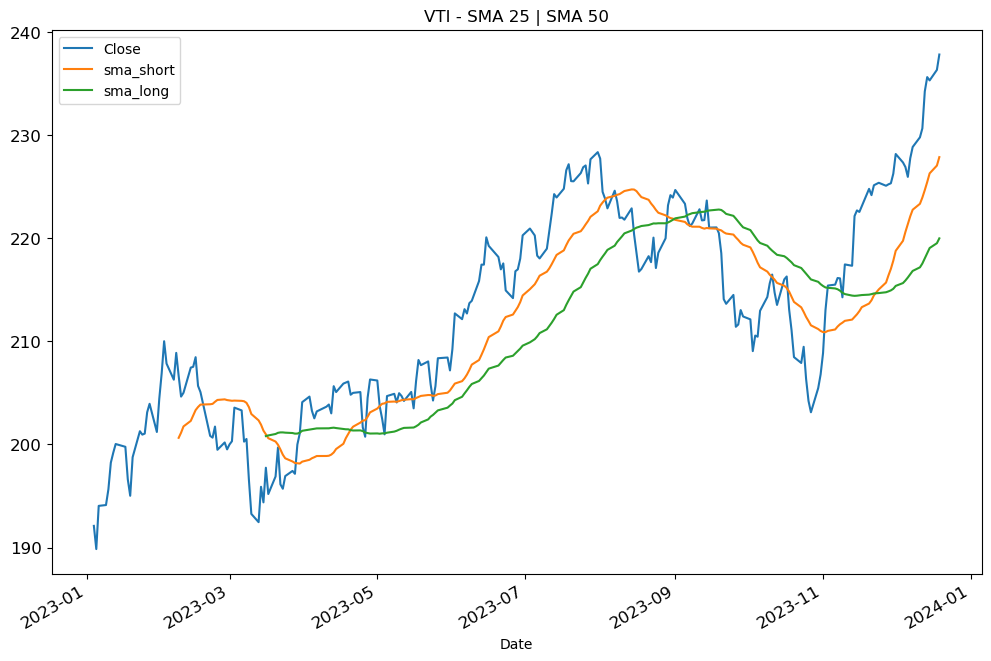

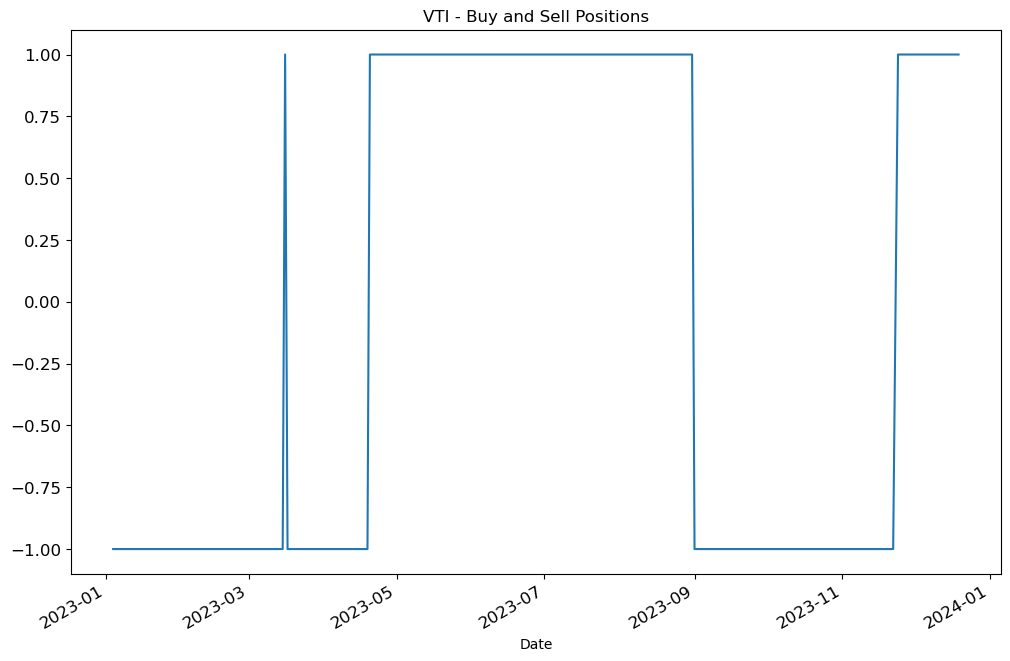

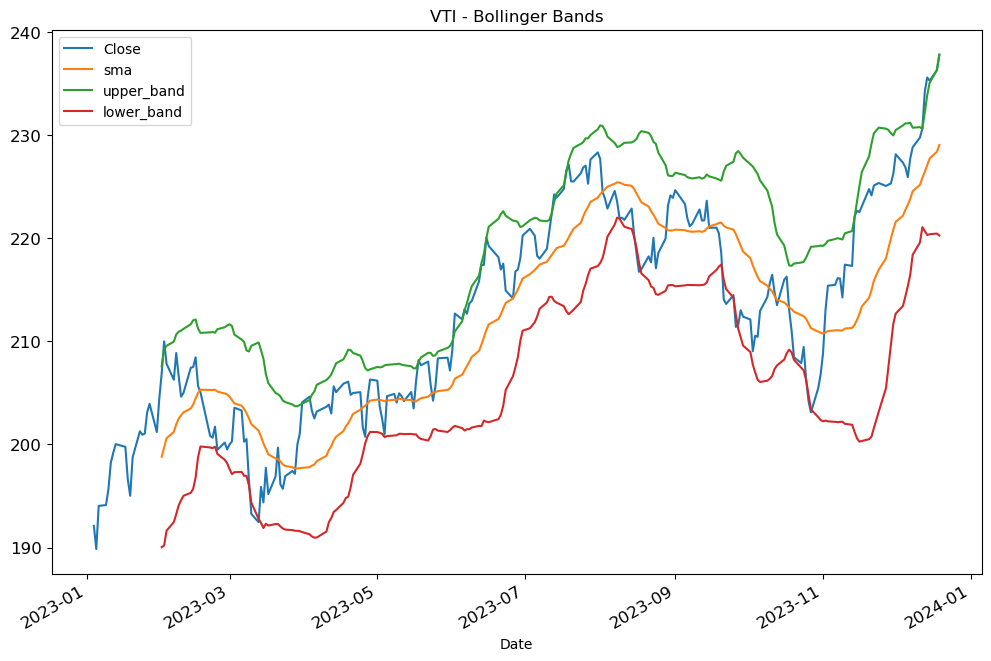

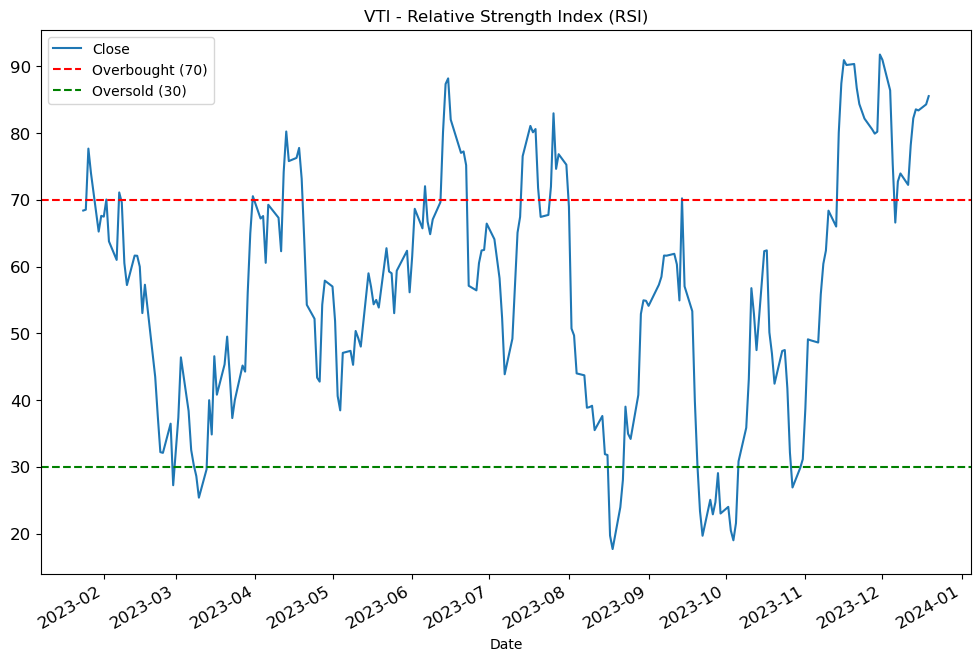

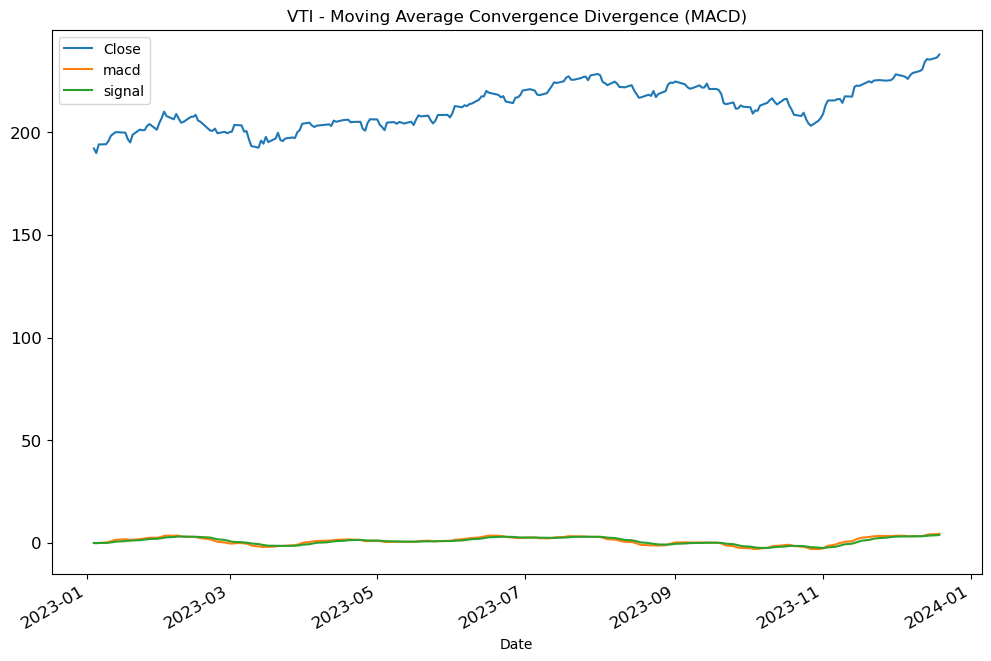

Total Return: 24.90%
Annualized Return: 26.05%
Annualized Volatility: 13.66%
Sharpe Ratio: 1.91


In [44]:
combined_analysis('VTI', start_date='2023-01-01', end_date='2023-12-31')

[*********************100%***********************]  1 of 1 completed


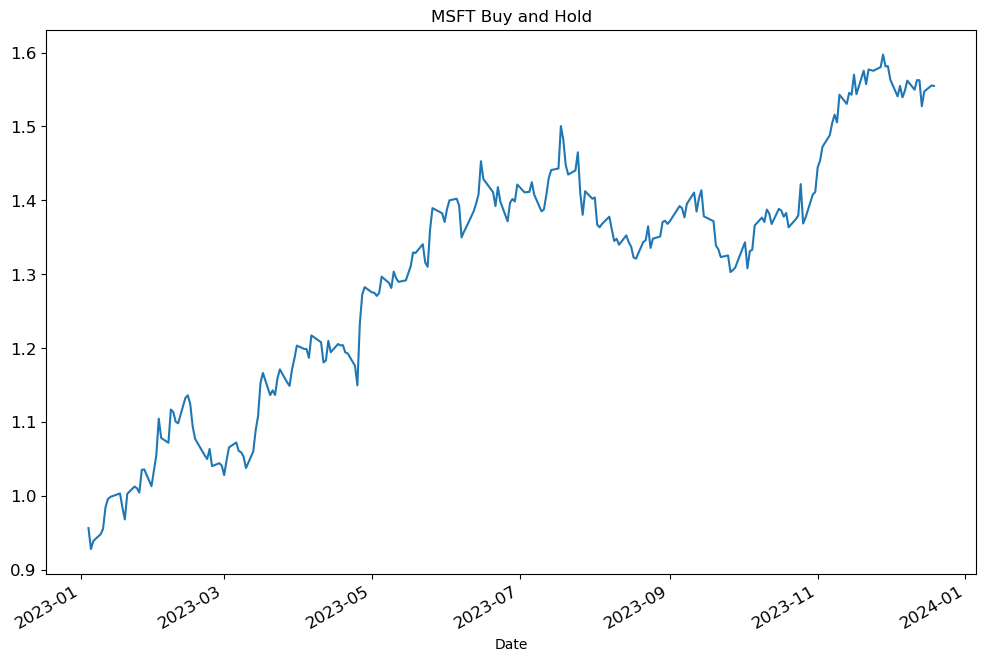

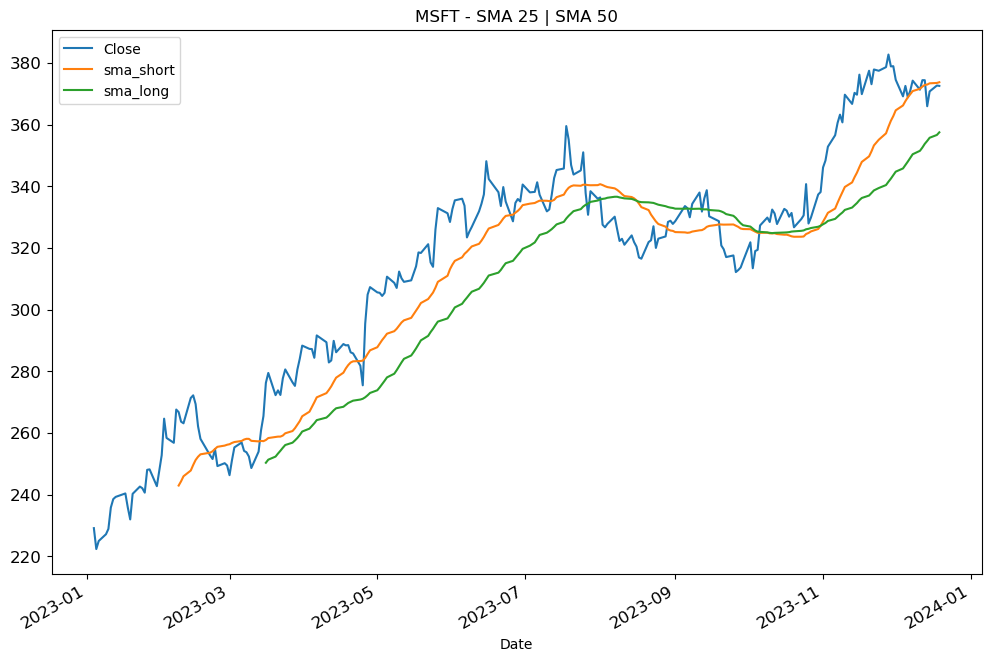

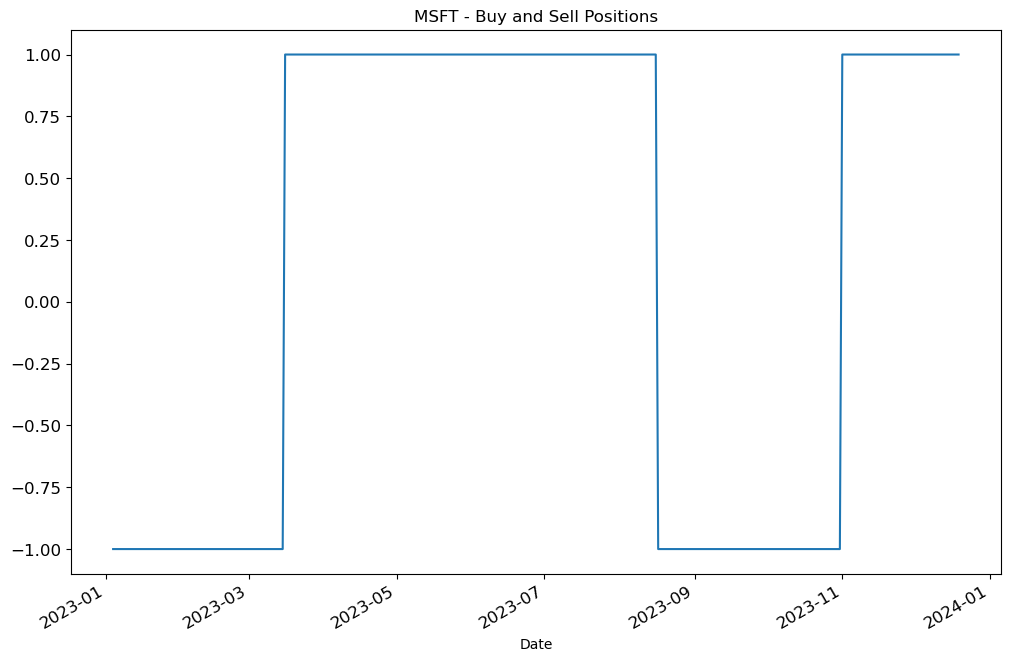

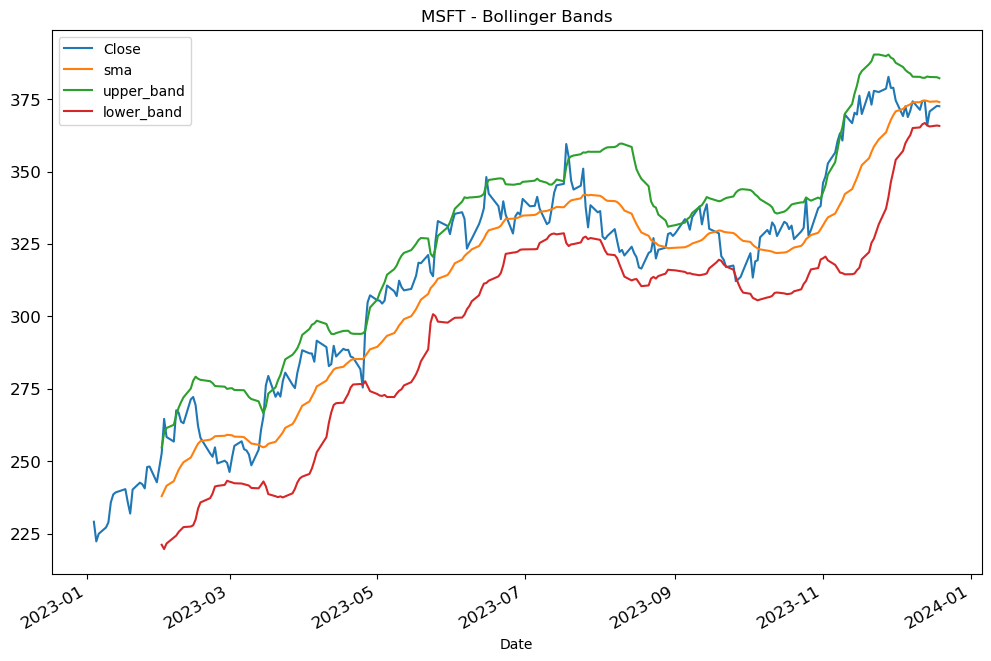

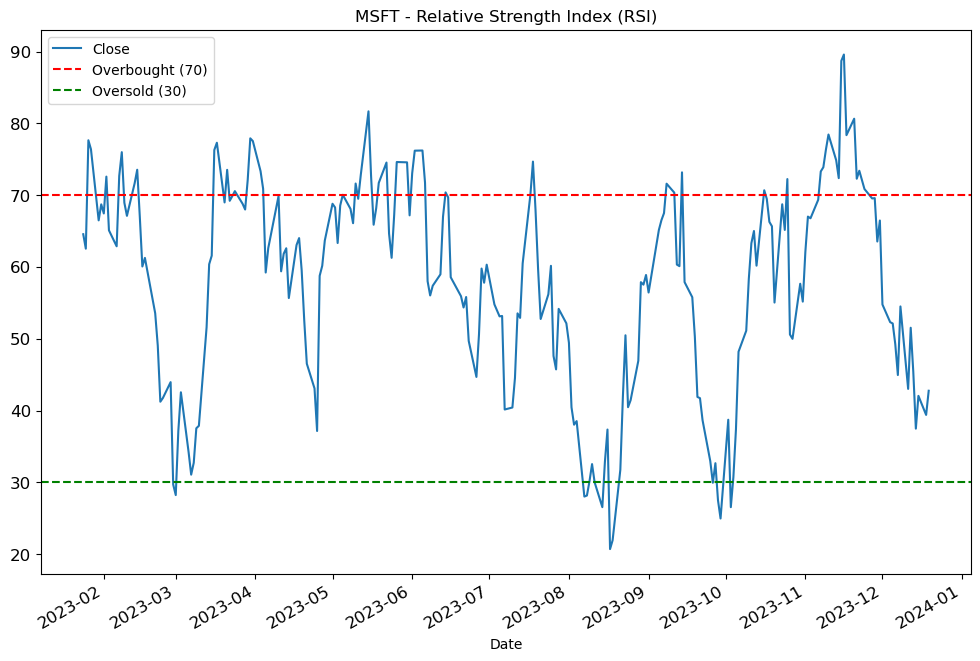

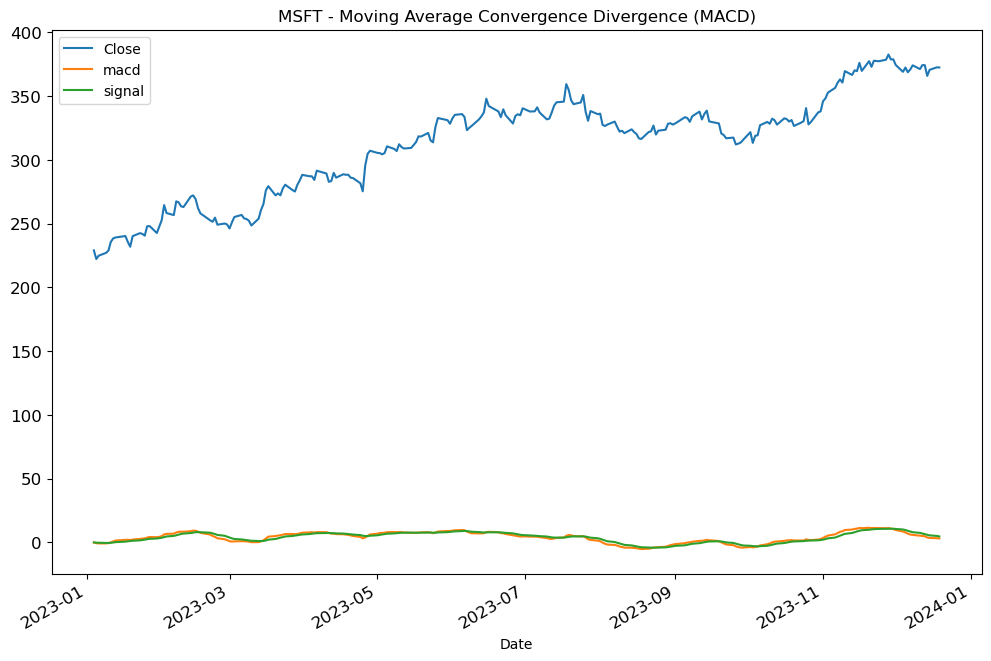

Total Return: 55.49%
Annualized Return: 58.36%
Annualized Volatility: 25.36%
Sharpe Ratio: 2.30


In [45]:
combined_analysis('MSFT', start_date='2023-01-01', end_date='2023-12-31')

[*********************100%***********************]  1 of 1 completed


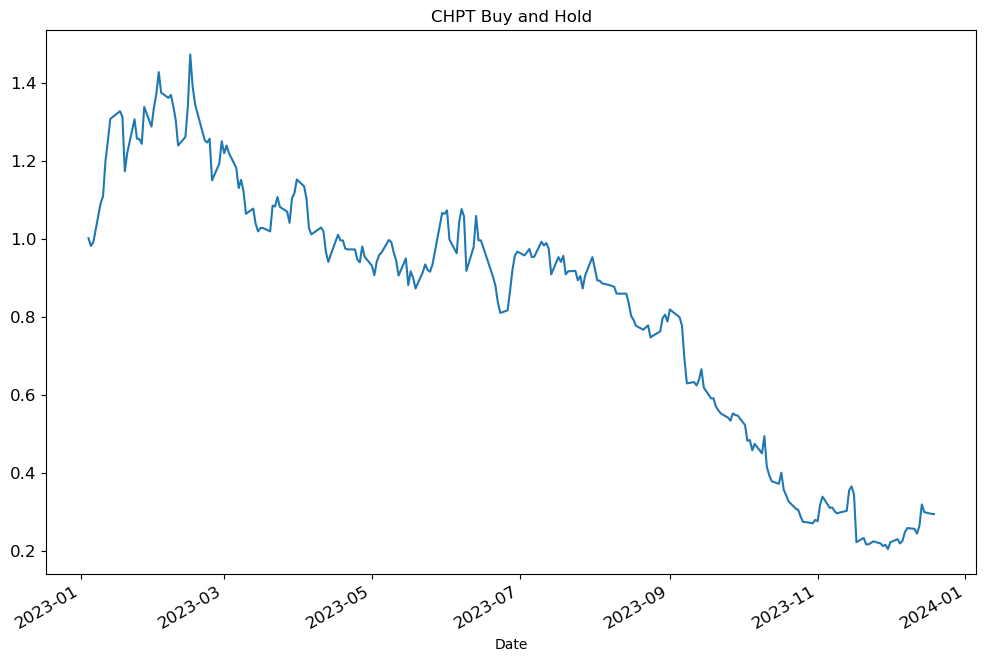

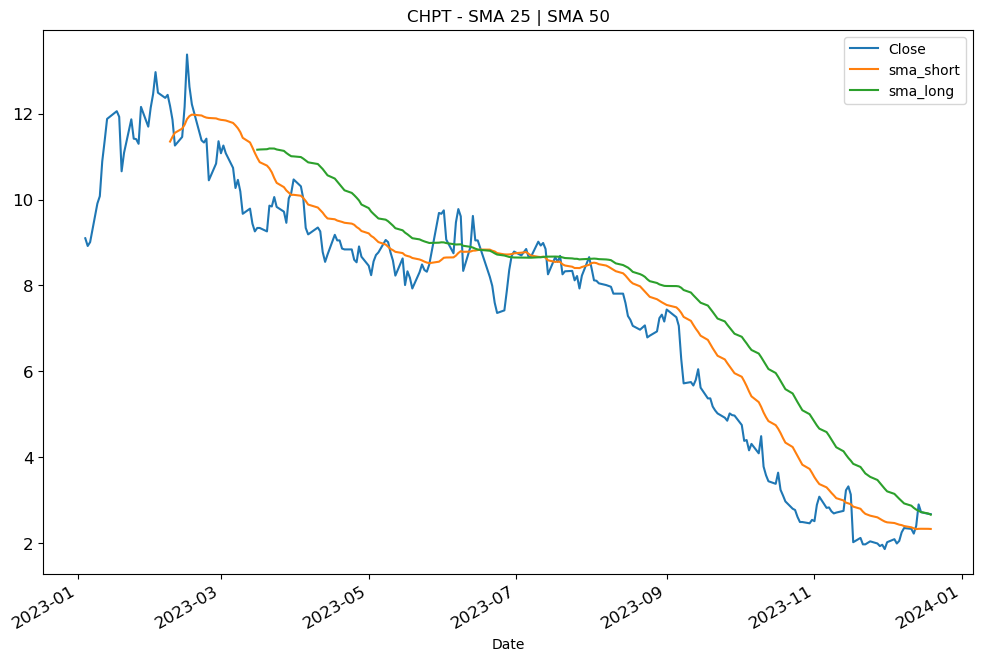

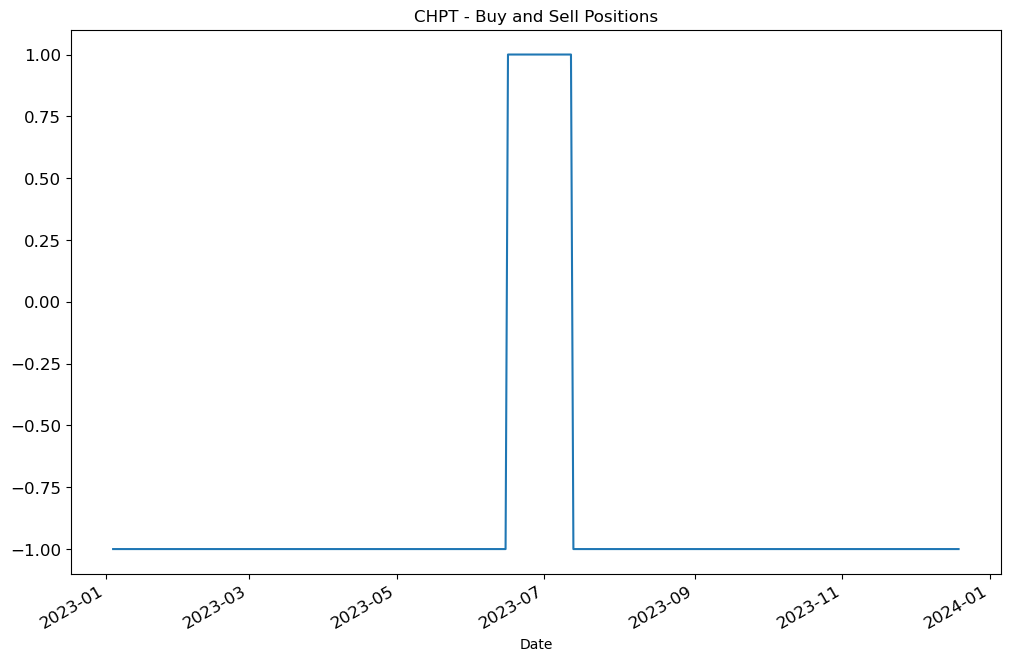

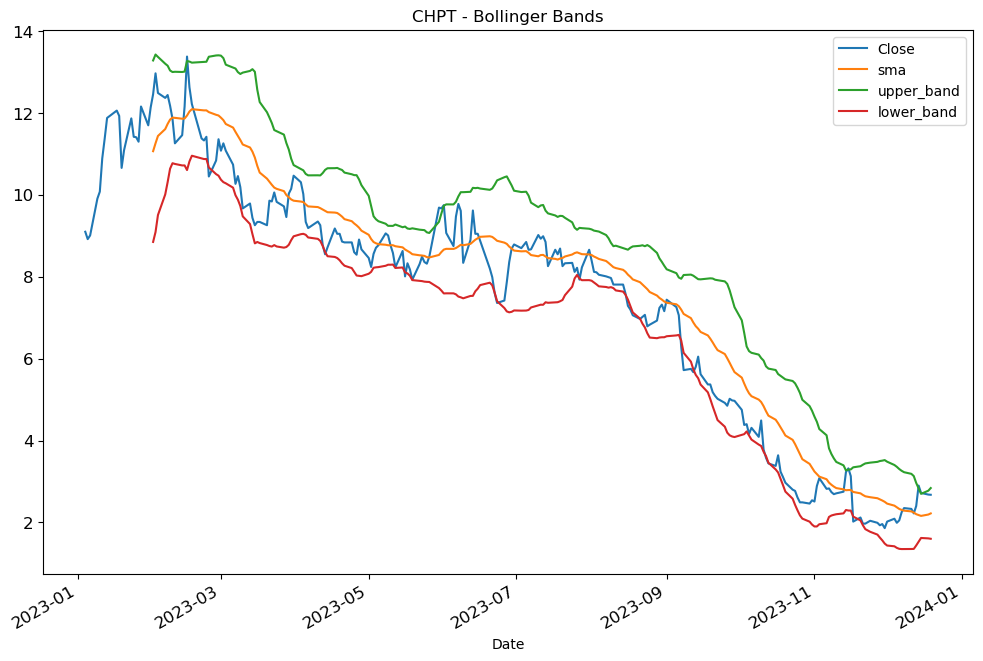

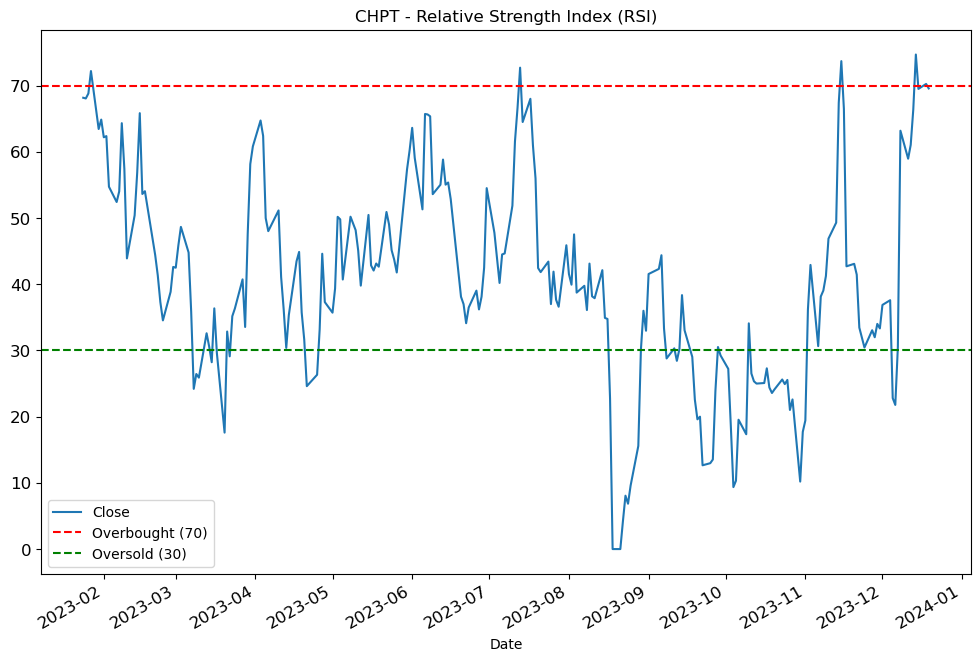

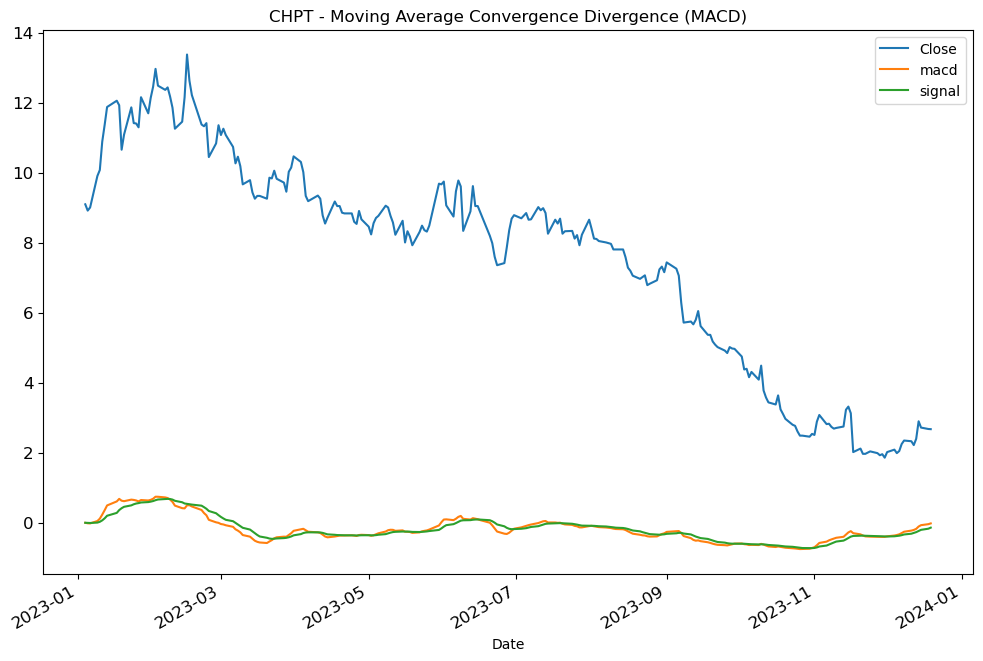

Total Return: -70.57%
Annualized Return: -72.02%
Annualized Volatility: 87.25%
Sharpe Ratio: -0.83


In [47]:
combined_analysis('CHPT', start_date='2023-01-01', end_date='2023-12-31')

[*********************100%***********************]  1 of 1 completed


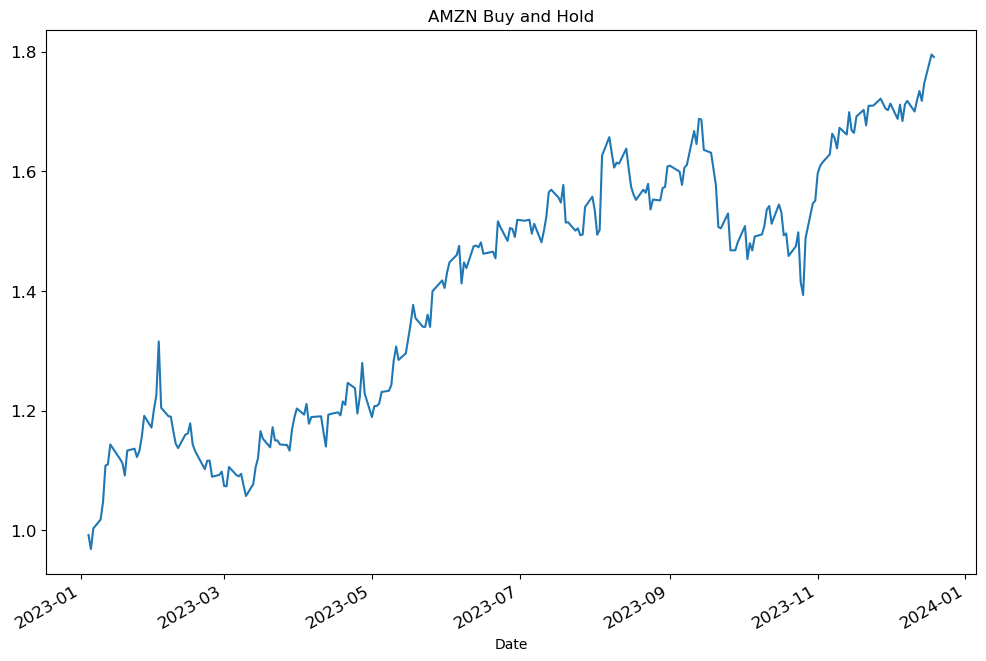

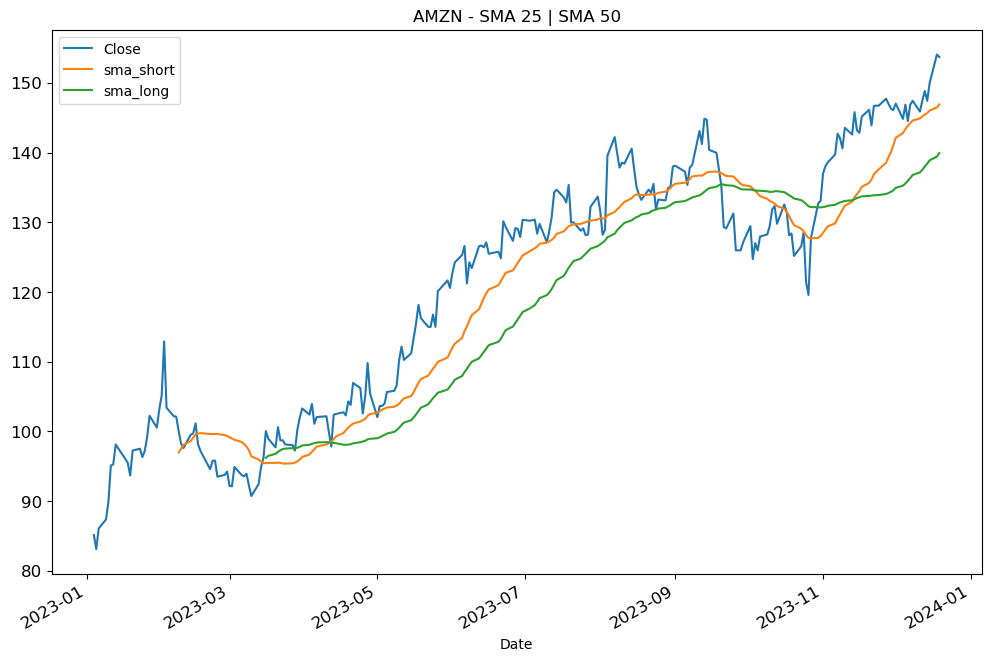

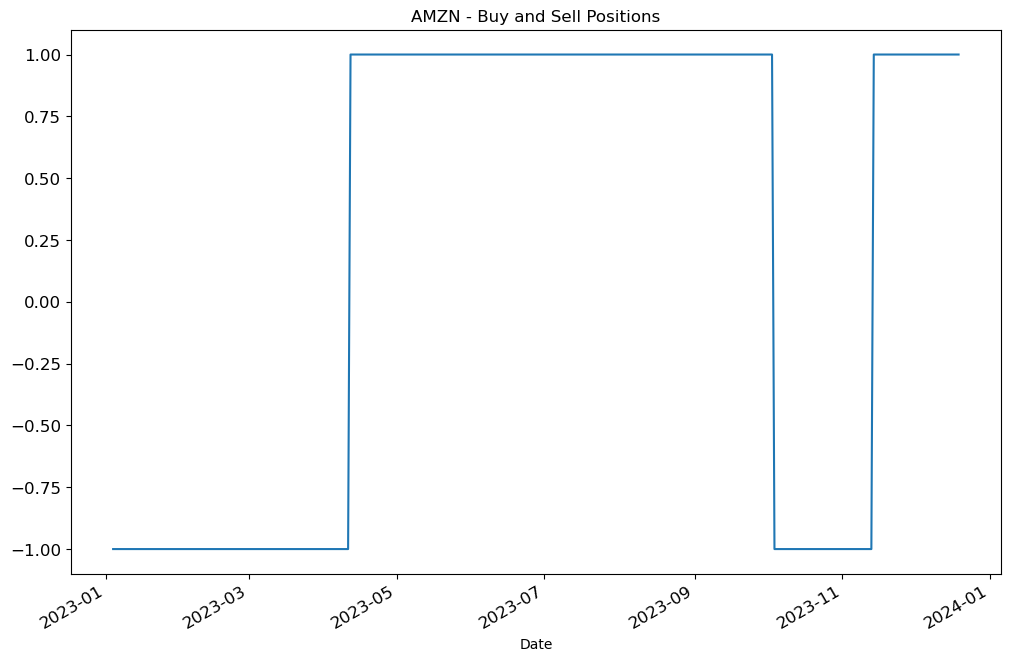

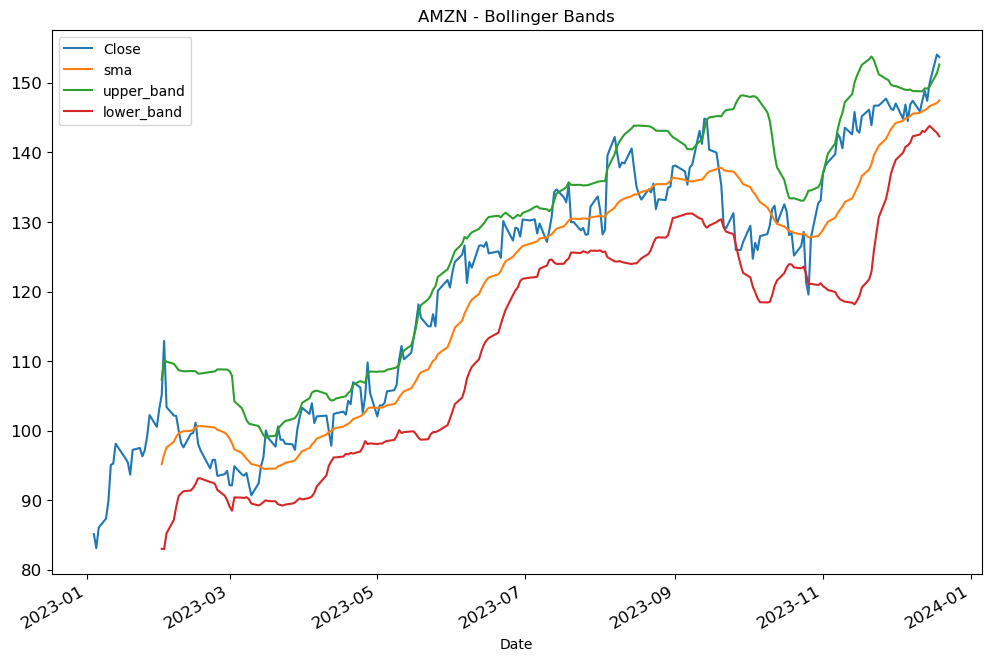

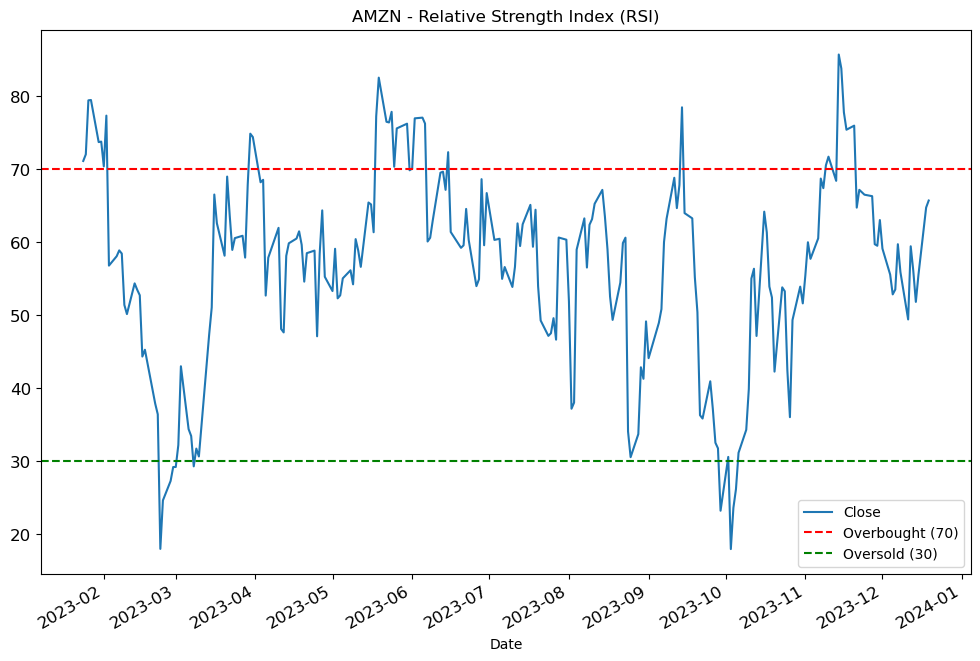

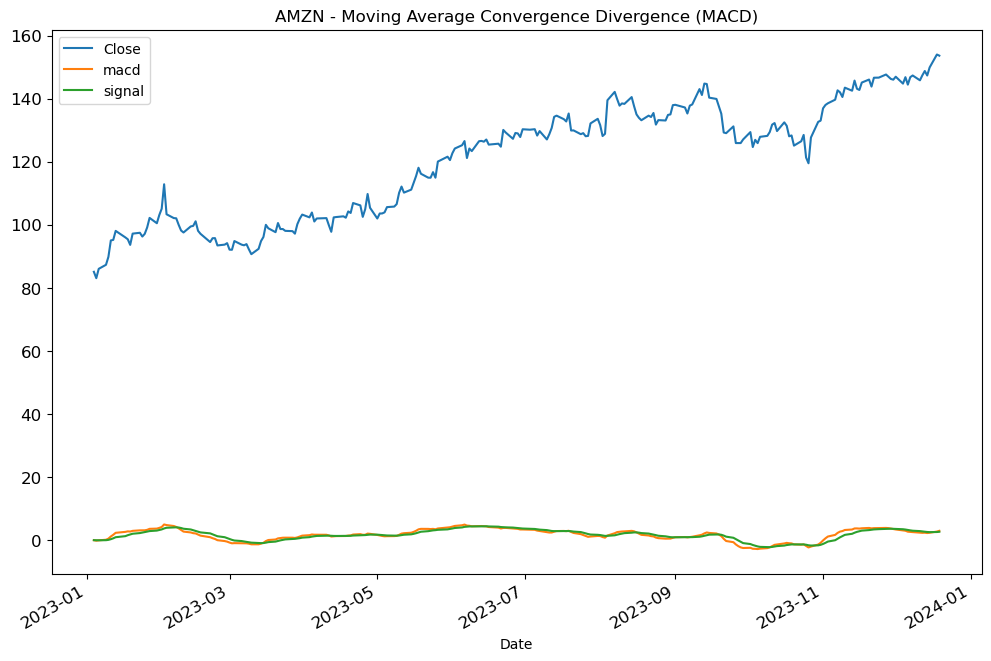

Total Return: 79.11%
Annualized Return: 83.47%
Annualized Volatility: 33.33%
Sharpe Ratio: 2.50


In [49]:
combined_analysis('AMZN', start_date='2023-01-01', end_date='2023-12-31')

[*********************100%***********************]  1 of 1 completed


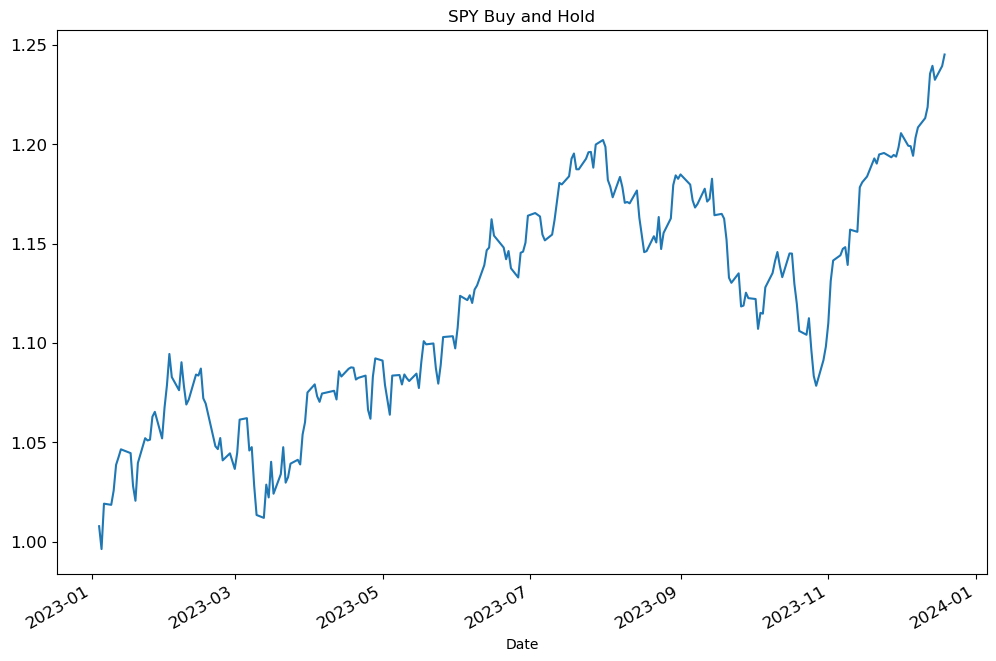

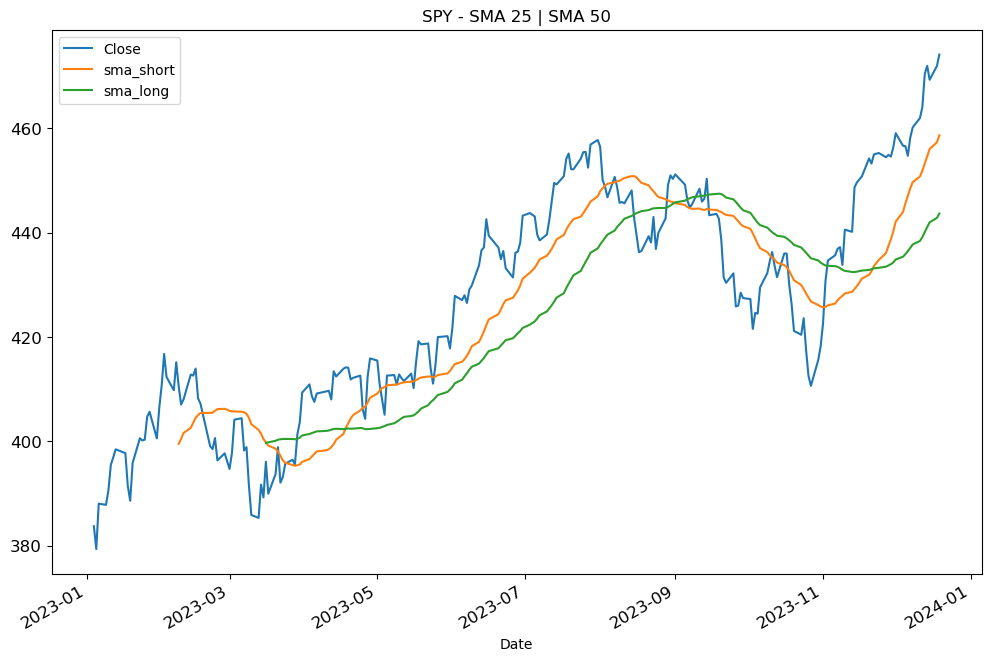

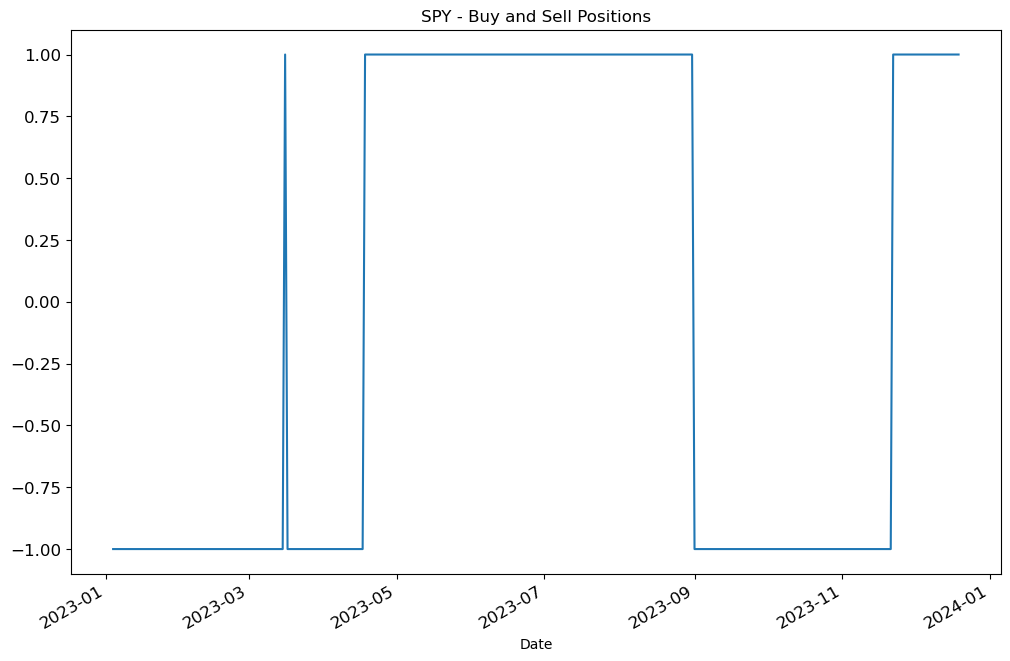

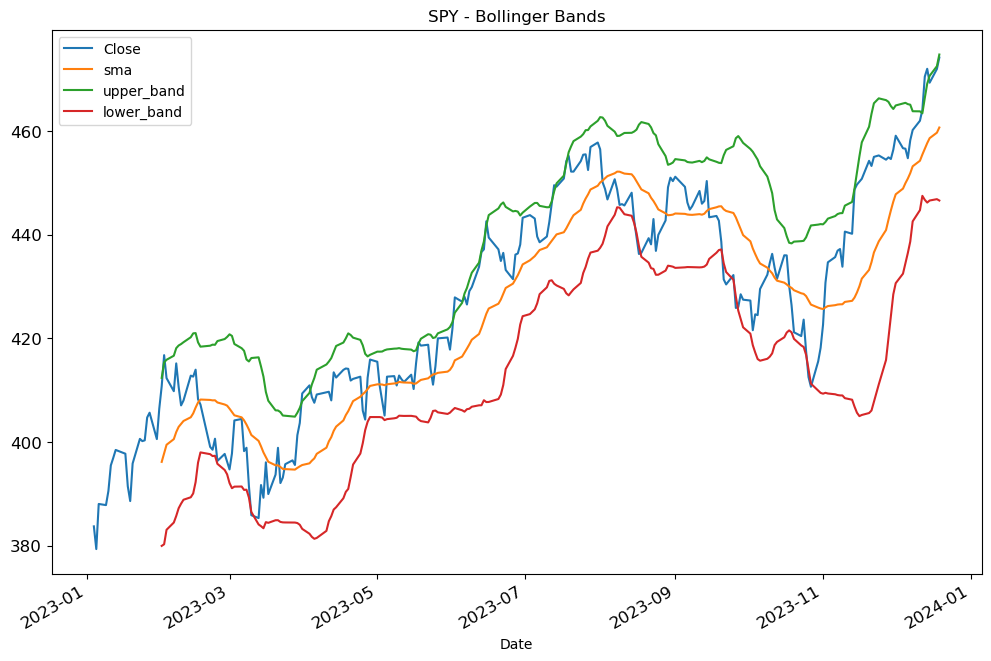

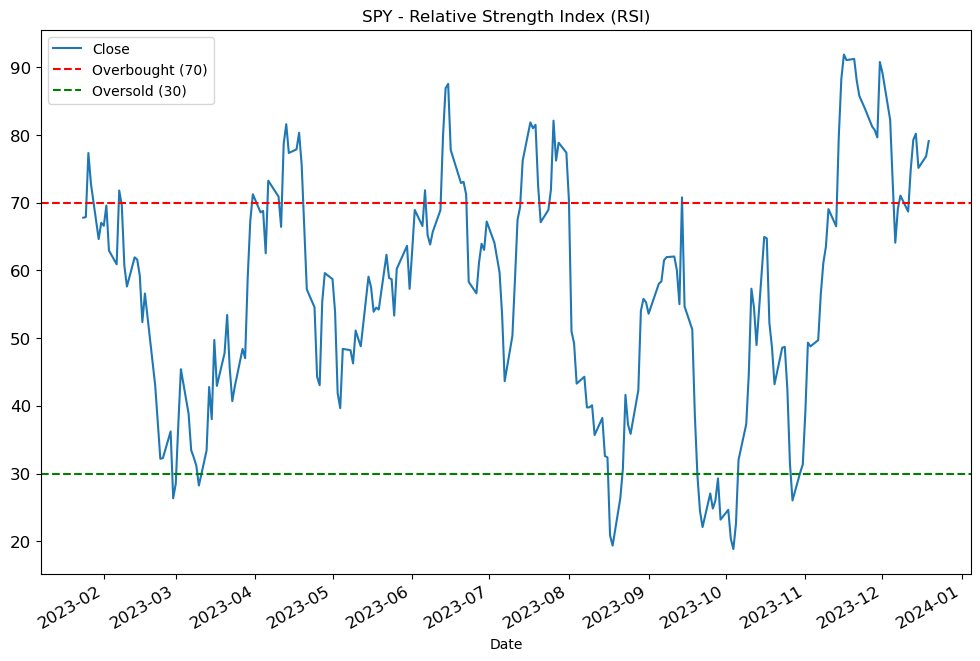

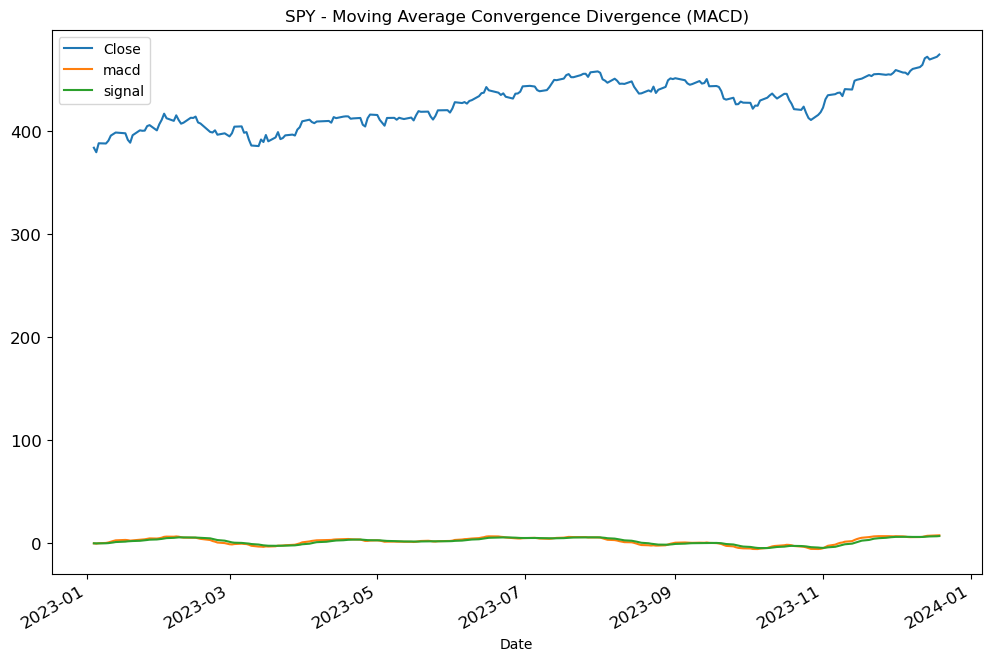

Total Return: 24.51%
Annualized Return: 25.65%
Annualized Volatility: 13.26%
Sharpe Ratio: 1.93


In [50]:
combined_analysis('SPY', start_date='2023-01-01', end_date='2023-12-31')